## <span style="color:white">Data Science Immersive Capstone Project</span>
### <span style="color:#CCC">Chris Huber, chrishubersf@gmail.com</span>
#### <span style="color:#AAA">A predictive study of edible wild mushroom growth in the greater San Francisco Bay Area</span>

### <span style="color:white">Problem Statement</span>
<div style="margin-left: 30px; margin-right: 30px;">
<p>Given prior data records of findings of edible wild edible mushroom species with latitude/longitude coordinates, species names, dates of sightings, weather conditions, <strikethrough>substrate composition</strikethrough>, and other relevant factors can I predict for a given period the likelihood of finding certain species of mushrooms that grow natively in the Bay Area.</p>
</div>

#### Add modeling hows/steps/flowchart? (going forward)
#### Visualizations

### <span style="color:white">Proposed Methods and Models</span>
<div style="margin-left: 30px; margin-right: 30px;">
<p>I propose to use MySQL as a database backend and Python/Pandas as the main technologies to analyze and deliver my findings</p>
<p>Sourcing the data is tricky: the records I have been able to find are often partial, imperfect, and even potentially inaccurate. However, the source is a reputable and well-known one among mycologists and as such I should be able to detect improperly formatted or submitted data with some thorough EDA.</p>
<p>An abundance of weather data has been and continues to be published daily by the U.S. Meterological Service and as such I should be able to import the relevant data from their website.</p>
<p>Mushrooms blooms in the Bay Area tend to occur during wet winter seasons. However, if the winter is dry they can be delayed until the spring. I intend to look at the correlation between the reported find dates and seasonal variations in temperature, precipitation, and humidity.
</div>

### <span style="color:white">Risks and Assumptions of Data</span>
<div style="margin-left: 30px; margin-right: 30px;">
<p>One of the major risks of this dataset is that it does not record quantity, simply occurrences. This means that while the mushrooms of the same species typically grow in a given area, there is no guarantee of the amount. Thus, this should not be seen as a guide to finding any particular amount of a given mushroom but rather its existence in an area.</p>
<p>Another risk is that the mushroom-related data is user-entered and as such could be erroneous or even outright false. However, there would be no perceivable benefit to falsifying this type of data so I do not forsee this being a major issue. I will need to monitor for gross anomolies in the data in cae this type of phenomenon exists.</p>
</div>

### <span style="color:white">Data Sources</span>
<div style="margin-left: 30px; margin-right: 30px;">
<p>
My main data source is a MySQL database dump that the curator for Mushroom Observer, a user-submitted mushroom documenting website, released to me. I also have data listing the species of mushrooms showcased at the San Francisco Fungus Fair (SFFF) and the general location where they were found. If possible, I intend to combine as much data as I can from different sources to create an even more robust dataset.
</p>
</div>

### <span style="color:white">Importing all Required Python Libraries</span>

In [688]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import MySQLdb
import math
import mplleaflet

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, RobustScaler
# from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, BaggingClassifier, RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder

ss = StandardScaler()
skb = SelectKBest(f_classif, k=6)

from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 999)

### <span style="color:white">Creating a MySQL Connection</span>

In [689]:
mysql_cn= MySQLdb.connect(host='localhost', 
                port=3306,user='capstone', passwd='mushr0Om', 
                db='mushroom_observer')
mush_obsv_df = pd.read_sql('SELECT * from bay_area_observations;', con=mysql_cn)
mush_obsv_df = mush_obsv_df.set_index(['id'])
mush_names_df = pd.read_sql('SELECT * from bay_area_names;', con=mysql_cn)
mush_names_df = mush_names_df.set_index(['id'])
mush_locs_df = pd.read_sql('SELECT * from bay_area_locations;', con=mysql_cn)
mush_locs_df = mush_locs_df.set_index(['id'])
# print('Loaded dataframe from MySQL. Records:', len(mush_df))

# mush_obsv.head()
mush_locs_df.head(1)

version          created_at          updated_at  user_id  description_id  \
id                                                                             
21  3       2008-01-04 22:48:03 2010-08-14 01:56:45  1       NaN               

    rss_log_id  num_views           last_view    north   south     west  \
id                                                                        
21 NaN          219       2018-09-05 19:40:30  38.1464  38.039 -122.624   

       east  high  low  ok_for_export  \
id                                      
21 -122.486 NaN   NaN   1               

                                                                                                                                     notes  \
id                                                                                                                                           
21  [admin - Sat Aug 14 01:56:45 +0000 2010]: Changed location name from 'Novato, Marin Co., California, USA' to 'Novato, California, USA'   

                       name          scientific_name  locked  
id                                                            
21  Novato, California, USA  USA, California, Novato  0

### Edible Mushroom List
<pre>
Agaricus augustus - The Prince (not choice)
Agaricus subrutilescens - Wine-colored Agaricus (choice)
Amanita augusta - Blushing Yellow Veil Amanita (not choice)
Amanita caesarea - Caesar's Mushroom
Amanita calyptroderma - Coccora, Coccoli
Amanita novinupta - Blusher (choice)
Amanita sect. Vaginatae (Amanita vaginata) - Grisette (not choice)
Amanita velosa - Springtime Amanita
Armillaria mellea
Auricularia auricula-judae - Jew's ear, wood ear, or jelly ear mushroom
Boletus badius - Bay Bolete
Boletus edulis - Porcini mushroom
Boletus edulis var. grandedulis
Boletus regineus - Queen Bolete (choice)
Calvatia gigantea - Giant Puffball
Cantharellus californicus - oak chanterelle (choice)
Cantharellus cibarius - yellow chanterelle (choice)
Cantharellus tubaeformis - tube or yellow-leg chanterelle
Chlorophyllum brunneum - Shaggy parasol (choice, but not recommended)
Clavaria fragilis - Fairy Fingers (not choice)
Clitocybe nuda (Lepista nuda) - Wood Blewit (choice)
Coprinellus micaceus - Mica Cap, Shiny Cap, and Glistening Inky Cap (choice)
Coprinus comatus - Shaggy Ink Cap/Mane, Lawyer's Wig (choice)
Entoloma medianox - Midnight Entoloma (choice)
Flammulina velutipes - Enoki mushroom (choice)
Gliophorus psittacinus - Parrot Toadstool, Parrot Waxcap *
Gomphidius oregonensis - Insidious Gomphidius (not choice) 
Grifola frondosa - Hen of the Woods
Gymnopus dryophilus (not choice)
Hericium erinaceus - lion's mane mushroom (choice)
Himematsutake - "princess matsutake"
Hydnum repandum - Hedgehog mushroom/Urchin of the Woods
Hypsizygus tessellatus/Hypsizygus marmoreus - beech mushroom, white/brown varieties
Laccaria amethysteo-occidentalis
Lacrymaria lacrymabunda (not choice) *
Lactarius deliciosus - Saffron Milk Cap
Lactarius rubidus - Candy Cap, Curry Milk Cap
Lactarius rufulus - Rufous Candy Cap
Laetiporus gilbertsonii *
Leccinum manzanitae - Manzanita Bolete (choice)
Lentinula edodes - shiitake (choice)
Morchella - Morel family
Morchella conica var. deliciosa - Morel
Morchella esculenta var. rotunda - Morel
Panaeolus papilionaceus - Petticoat mottlegill (not choice)
Pleurotus, Pleurotus ostreatus - oyster mushrooms
Pluteus cervinus - Deer Shield, Deer/Fawn mushroom (not choice)
Schizophyllum commune (not choice) *
Suillus fuscotomentosus
Suillus pungens - pungent slippery jack (not choice)
Tremella fuciformis - snow fungus, snow ear, silver ear fungus, and white jelly mushroom
Tricholoma matsutake - matsutake
Tuber aestivum - Black summer truffle
Tuber birch
Tuber brumale
Tuber indicum - Chinese black truffle
Tuber macrosporum - Smooth black truffle
Tuber mesentericum - The Bagnoli truffle
Volvariella volvacea - paddy straw mushroom or straw mushroom
Volvopluteus gloiocephalus - Big Sheath mushroom, Rose-Gilled Grisette, or Stubble Rosegill (not choice)
</pre>

* for some

### Medicinal Mushroom List
<pre>
Panaeolus foenisecii - Mower's Mushroom, Brown Hay Mushroom
Trametes betulina - Gilled Polypore, Birch Mazegill, Multicolor Gill 
Trametes versicolor - Turkey Tail
Tremella fuciformis - snow fungus, snow ear, silver ear fungus, and white jelly mushroom
</pre>

### Psychoactive Mushroom List
<pre>
Gymnopilus luteofolius - Yellow-Gilled Gymnopilus
Inocybe corydalina
Omphalotus olivascens
Panaeolus cinctulus (Panaeolus papilionaceus group) - Banded Mottlegill, Weed Panaeolus or Subbs
Psilocybe allenii
Psilocybe cyanescens - Wavy cap
</pre>

### Poisonous Mushroom List
<pre>
Agaricus californicus *
Agaricus hondensis - Felt-Ringed Agaricus
Agaricus xanthodermus *
Amanita amerimuscaria
Amanita gemmata - Gemmed Amanita
Amanita muscaria subsp. flavivolvata
Amanita phalloides
Amanita ocreata
Boletus eastwoodiae - Satan's Bolete *
Chlorophyllum molybdites - Vomiter Mushroom
Galerina marginata - Funeral Bell, Deadly Skullcap
Hebeloma crustuliniforme - Poison Pie, Fairy Cakes
Hypholoma fasciculare - Sulfur Tuft
Inocybe geophylla% - Common White Inocybe, Earthy Inocybe, White Fibercap
Leratiomyces ceres - Redlead Roundhead
Psathyrella
Omphalotus olivascens
Suillellus amygdalinus *

* for some
</pre>

### Other Scientific Interest List
<pre>
Amanita magniverrucata - Great Pine Jewel
Annulohypoxylon thouarsianum
Aureoboletus flaviporus
Bolbitius titubans
Caulorhiza umbonata
Clathrus ruber - Latticed Stinkhorn, Basket Stinkhorn, Red Cage
Coprinellus sect. Micacei
Coprinopsis lagopus - Harefoot mushroom
Cortinarius glutinosoarmillatus - Slimy Belt
Cortinarius subgenus Telamonia
Entoloma subgenus Leptonia
Entoloma subgenus Nolanea
Ganoderma brownii
Gymnopilus luteofolius
Gymnopilus ventricosus
Helvella dryophila
Hericium coralloides - Coral tooth
Hygrocybe acutoconica
Hygrocybe flavescens
Hygrocybe singeri
Hygrophorus eburneus - Ivory Waxy Cap or the Cowboy's Handkerchief *
Phaeolus schweinitzii - Velvet-top Fungus, Dyer's Polypore
Lactarius alnicola - Golden milk cap
Lactarius argillaceifolius var. megacarpus
Leratiomyces percevalii
Leucopaxillus albissimus
Marasmiellus candidus
Marasmius plicatulus
Mycena acicula - Orange Bonnet, Coral Spring
Mycena galericulata - Common Bonnet, Toque Mycena, Rosy-Gill Fairy Helmet
Mycena haematopus - Bleeding Fairy Helmet, Burgundydrop Bonnet
Mycena purpureofusca - Purple-Edge Bonnet
Panus conchatus - Lilac Oysterling
Psathyrella candolleana
Psathyrella longipes
Psathyrella piluliformis
Russula cremoricolor
Russula sanguinaria (Russula sanguinea) - Bloody Brittlegill
Stereum hirsutum - False turkey tail
Stropharia ambigua
Suillus caerulescens
Tremella aurantia - Golden ear
Tricholoma dryophilum
Tubaria furfuracea - Scurfy twiglet
Xylaria hypoxylon ("Xylaria hypoxylon group") - candlestick fungus, carbon antlers, stag's horn fungus
</pre>

In [690]:
### MAKE HISTOGRAM OF EDIBLE MUSHROOM DISTRIBUTIONS!!

In [691]:
# edible_mushroom_list = ['Amanita velosa', 'Pleurotus ostreatus', 'Boletus edulis', 'Boletus badius', 'Cantharellus californicus', 
#                         'Cantharellus cibarius', 'Cantharellus tubaeformis', 'Chlorophyllum brunneum'
#                         'Calvatia gigantea', 'Lentinula edodes', 'Auricularia auricula-judae', 'Volvariella volvacea',
#                         'Flammulina velutipes', 'Hericium erinaceus', 'Tremella fuciformis', 'Hypsizygus tessellatus',
#                         'Hypsizygus marmoreus', 'Grifola frondosa', 'Hydnum repandum', 'Lactarius deliciosus', 'Tricholoma matsutake',
#                         'Himematsutake', 'Morchella conica', 'Morchella esculenta', 'Tuber aestivum', 'Tuber birch', 'Tuber brumale',
#                         'Tuber indicum', 'Tuber macrosporum', 'Tuber mesentericum', 'Amanita caesarea', 'Armillaria mellea'
#                        ]

choice_mushroom_list = ['Agaricus subrutilescens','Amanita novinupta','Boletus edulis','Boletus edulis var. grandedulis','Boletus regineus','Cantharellus californicus','Cantharellus cibarius','Cantharellus tubaeformis','Chlorophyllum brunneum','Clitocybe nuda','Lepista nuda','Coprinellus micaceus','Coprinus comatus','Entoloma medianox','Flammulina velutipes','Grifola frondosa','Hericium erinaceus','Himematsutake','Lactarius deliciosus','Lactarius rubidus','Lactarius rufulus','Leccinum manzanitae','Lentinula edodes','Morchella conica var. deliciosa','Morchella esculenta var. rotunda','Tremella fuciformis','Tricholoma matsutake','Tuber aestivum','Tuber birch','Tuber brumale','Tuber indicum','Tuber macrosporum','Tuber mesentericum','Volvariella volvacea']
edible_mushroom_list = ['Amanita caesarea','Amanita calyptroderma','Amanita velosa','Armillaria mellea','Auricularia auricula-judae','Gliophorus psittacinus','Hydnum repandum','Hypsizygus tessellatus/Hypsizygus marmoreus','Laccaria amethysteo-occidentalis','Suillus fuscotomentosus']
not_choice_mushroom_list = ['Agaricus augustus','Amanita augusta','Amanita sect. Vaginatae ','Amanita vaginata','Boletus badius','Calvatia gigantea','Clavaria fragilis','Gomphidius oregonensis','Gymnopus dryophilus','Lacrymaria lacrymabunda','Laetiporus gilbertsonii','Panaeolus papilionaceus','Pleurotus ostreatus','Pluteus cervinus','Suillus pungens','Volvopluteus gloiocephalus']

poisonous_mushroom_list = ['Agaricus californicus','Agaricus hondensis','Agaricus xanthodermus','Amanita amerimuscaria','Amanita gemmata','Amanita muscaria subsp. flavivolvata','Amanita phalloides','Amanita ocreata','Boletus eastwoodiae','Chlorophyllum molybdites','Galerina marginata','Hebeloma crustuliniforme','Hypholoma fasciculare','Inocybe geophylla','Leratiomyces ceres','Omphalotus olivascens','Suillellus amygdalinus']
psychoactive_mushroom_list = ['Gymnopilus luteofolius', 'Inocybe corydalina', 'Omphalotus olivascens', 'Panaeolus cinctulus', 'Panaeolus papilionaceus group', 'Psilocybe allenii', 'Psilocybe cyanescens']
other_mushroom_list = ['Amanita magniverrucata','Annulohypoxylon thouarsianum','Aureoboletus flaviporus','Bolbitius titubans','Caulorhiza umbonata','Clathrus ruber','Coprinellus sect. Micacei','Coprinopsis lagopus','Cortinarius glutinosoarmillatus','Cortinarius subgenus Telamonia','Entoloma subgenus Leptonia','Entoloma subgenus Nolanea','Ganoderma brownii','Gymnopilus luteofolius','Gymnopilus ventricosus','Helvella dryophila','Hericium coralloides','Hygrocybe acutoconica','Hygrocybe flavescens','Hygrocybe singeri','Hygrophorus eburneus','Phaeolus schweinitzii','Lactarius alnicola','Lactarius argillaceifolius var. megacarpus','Leratiomyces percevalii','Leucopaxillus albissimus','Marasmiellus candidus','Marasmius plicatulus','Mycena acicula','Mycena galericulata','Mycena haematopus','Mycena purpureofusca','Panus conchatus','Psathyrella candolleana','Psathyrella longipes','Psathyrella piluliformis','Russula cremoricolor','Russula sanguinaria','Russula sanguinea','Stereum hirsutum','Stropharia ambigua','Suillus caerulescens','Tremella aurantia','Tricholoma dryophilum','Tubaria furfuracea','Xylaria hypoxylon','Xylaria hypoxylon group']

# print('|'.join(choice_mushroom_list))
print(len(choice_mushroom_list))

34


In [692]:
### exact name search
# def get_mushrooms_by_exact_species(species_list):
#     species_input = ', '.join('"{0}"'.format(species) for species in species_list)
#     query = "SELECT bay_area_observations.id, bay_area_observations.created_at, bay_area_names.text_name, bay_area_locations.name, north, south, east, west FROM bay_area_observations LEFT JOIN bay_area_names ON bay_area_observations.name_id = bay_area_names.id LEFT JOIN bay_area_locations ON bay_area_observations.location_id = bay_area_locations.id WHERE bay_area_names.text_name IN (" + species_input + ") ORDER BY text_name;"
#     mush_by_species_df = pd.read_sql(query, con=mysql_cn)
#     return mush_by_species_df

### Defining dictionary of overlapping mushroom names to unify

In [693]:
mush_merge_dict = {
    'Agaricus augustus group': 'Agaricus augustus',
    'Agaricus subrutilescens group': 'Agaricus subrutilescens',
    'Amanita novinupta group': 'Amanita novinupta',
    'Amanita vaginata group': 'Amanita vaginata',
    'Armillaria mellea group': 'Armillaria mellea',
    'Boletus edulis var. grandedulis': 'Boletus edulis',
    'Clavaria fragilis group': 'Clavaria fragilis',
    'Coprinellus micaceus group': 'Coprinellus micaceus',
    'Entoloma medianox f. eos': 'Entoloma medianox',
    'Flammulina velutipes group': 'Flammulina velutipes', 
    'Flammulina velutipes var. lupinicola': 'Flammulina velutipes', 
    'Flammulina velutipes var. velutipes': 'Flammulina velutipes',
    'Gliophorus psittacinus group': 'Gliophorus psittacinus', 
    'Gliophorus psittacinus var. californicus': 'Gliophorus psittacinus',
    'Lactarius deliciosus group': 'Lactarius deliciosus',
    'Laetiporus gilbertsonii group': 'Laetiporus gilbertsonii',
    'Lepista nuda': 'Clitocybe nuda',
    'Panaeolus papilionaceus group': 'Panaeolus papilionaceus',
    'Pleurotus ostreatus group': 'Pleurotus ostreatus',
    'Pluteus cervinus group': 'Pluteus cervinus'
}
# mush_merge_dict = {v:k for k,v in mush_merge_dict.items()}

# for rename_to, rename_from in mush_merge_dict.items():
#    sandbox_df[sandbox_df['text_name'] == rename_from] = rename_to
    
# list(sandbox_df['text_name'].sort_values().unique())
mush_merge_dict

{'Agaricus augustus group': 'Agaricus augustus',
 'Agaricus subrutilescens group': 'Agaricus subrutilescens',
 'Amanita novinupta group': 'Amanita novinupta',
 'Amanita vaginata group': 'Amanita vaginata',
 'Armillaria mellea group': 'Armillaria mellea',
 'Boletus edulis var. grandedulis': 'Boletus edulis',
 'Clavaria fragilis group': 'Clavaria fragilis',
 'Coprinellus micaceus group': 'Coprinellus micaceus',
 'Entoloma medianox f. eos': 'Entoloma medianox',
 'Flammulina velutipes group': 'Flammulina velutipes',
 'Flammulina velutipes var. lupinicola': 'Flammulina velutipes',
 'Flammulina velutipes var. velutipes': 'Flammulina velutipes',
 'Gliophorus psittacinus group': 'Gliophorus psittacinus',
 'Gliophorus psittacinus var. californicus': 'Gliophorus psittacinus',
 'Lactarius deliciosus group': 'Lactarius deliciosus',
 'Laetiporus gilbertsonii group': 'Laetiporus gilbertsonii',
 'Lepista nuda': 'Clitocybe nuda',
 'Panaeolus papilionaceus group': 'Panaeolus papilionaceus',
 'Pleurotus

In [694]:
# s = choice_mushroom_list + edible_mushroom_list + not_choice_mushroom_list
# species_input = '|'.join(s)
# query = "SELECT bay_area_observations.id, bay_area_observations.created_at, bay_area_names.text_name, (north + south) / 2 AS latitude, (east + west) / 2 AS longitude FROM bay_area_observations LEFT JOIN bay_area_names ON bay_area_observations.name_id = bay_area_names.id LEFT JOIN bay_area_locations ON bay_area_observations.location_id = bay_area_locations.id WHERE bay_area_names.text_name REGEXP ('" + species_input + "') ORDER BY text_name;"
# mush_by_species_df = pd.read_sql(query, con=mysql_cn)

### Breaking Down Distribution Range Into Grid
#### The plotted area is 134 miles N-S and 85 miles E-W
#### Boundaries are 38.4228N - 364557N and 123.2710W - 121.5229W
##### Breakdown into 1/4 miles squares

In [695]:
def assign_grid(x):
    '''
    Assign grid code using the latitude and longitude of the original dataframe.
    '''
    # lat_range = (38.4228 - 36.4557) / 275
    # long_range = (-123.2710 - -121.5229) / 175
    lat_range = (38.4228 - 36.4557) / 550
    long_range = (-123.2710 - -121.5229) / 350
    
    return str(math.floor((x[3] - 36.4557) / lat_range)) + '_' + str(math.floor((-123.2710 - x[4]) / long_range))

In [696]:
def mushroom_count_by_species(species_list):
    species_input = '|'.join(species_list)
    # query = "SELECT bay_area_observations.id, bay_area_observations.created_at, bay_area_names.text_name, bay_area_locations.name, north, south, east, west, (north + south) / 2 AS latitude, (east + west) / 2 AS longitude FROM bay_area_observations LEFT JOIN bay_area_names ON bay_area_observations.name_id = bay_area_names.id LEFT JOIN bay_area_locations ON bay_area_observations.location_id = bay_area_locations.id WHERE bay_area_names.text_name REGEXP ('" + species_input + "') ORDER BY text_name;"
    query = "SELECT bay_area_observations.id, bay_area_observations.created_at, bay_area_names.text_name, (north + south) / 2 AS latitude, (east + west) / 2 AS longitude, IF(bay_area_locations.name LIKE '%redwood%' OR bay_area_locations.name LIKE '%basin%' OR bay_area_locations.name LIKE '%tilden%' OR bay_area_locations.name LIKE '%butano%' OR bay_area_locations.name LIKE '%henry cowel%', true, false) AS is_redwood, IF(bay_area_locations.name LIKE '%tamalpais%' OR bay_area_locations.name LIKE '%monte bello%' OR bay_area_locations.name LIKE '%corte de madera%' OR bay_area_locations.name LIKE '%stevens creek%' OR bay_area_locations.name LIKE '%monte bello%' OR bay_area_locations.name LIKE '%purisima%' OR bay_area_locations.name LIKE '%huddart%', true, false) AS is_fir, IF(bay_area_locations.name LIKE '%canyon%', true, false) AS is_canyon, IF(bay_area_locations.name LIKE '%china camp%' OR bay_area_locations.name LIKE '%golden gate%' OR bay_area_locations.name LIKE '%tilden%' OR bay_area_locations.name LIKE '%wildcat%' OR bay_area_locations.name LIKE '%briones%' OR bay_area_locations.name LIKE '%henry lowel%'  OR bay_area_locations.name LIKE '%oakland%' OR bay_area_locations.name LIKE '%redwood reg%' OR bay_area_locations.name LIKE '%puris%' OR bay_area_locations.name LIKE '%london%', true, false) AS is_oak FROM bay_area_observations LEFT JOIN bay_area_names ON bay_area_observations.name_id = bay_area_names.id LEFT JOIN bay_area_locations ON bay_area_observations.location_id = bay_area_locations.id WHERE bay_area_names.text_name REGEXP ('" + species_input + "') ORDER BY text_name;"
    # return query
    mush_by_species_df = pd.read_sql(query, con=mysql_cn)
    # for rename_to, rename_from in mush_merge_dict.items():
    #     mush_by_species_df[mush_by_species_df['text_name'] == rename_from] = rename_to
    mush_by_species_df['text_name'] = mush_by_species_df['text_name'].map(lambda x: x if x not in mush_merge_dict.keys() else mush_merge_dict[x])
    return mush_by_species_df

edible_by_species = mushroom_count_by_species(choice_mushroom_list + edible_mushroom_list + not_choice_mushroom_list)
# edible_by_species = mushroom_count_by_species(choice_mushroom_list + edible_mushroom_list)
# print(edible_by_species)
edible_by_species['grid_code'] = edible_by_species.apply(assign_grid, axis=1)
edible_by_species.head(25)

# list(edible_by_species['text_name'].sort_values().unique())
# edible_by_species.dtypes
# edible_by_species['grid_code'].value_counts()
# edible_by_species[edible_by_species['created_at'].isnull() == True]

id          created_at          text_name   latitude   longitude  \
0   67218  2011-05-11 22:10:54  Agaricus augustus  36.982649 -121.872498   
1   24690  2009-08-24 08:54:47  Agaricus augustus  37.769001 -122.483501   
2   191814 2014-12-05 18:08:54  Agaricus augustus  37.003799 -122.055500   
3   74559  2011-08-24 06:26:43  Agaricus augustus  36.891850 -121.711002   
4   56761  2010-10-26 23:57:43  Agaricus augustus  37.780701 -122.514000   
5   59054  2010-11-17 04:38:29  Agaricus augustus  36.990400 -122.058998   
6   21553  2009-06-02 18:59:21  Agaricus augustus  37.056599 -122.134998   
7   69255  2011-06-15 00:08:04  Agaricus augustus  37.777500 -122.511501   
8   250096 2016-08-29 06:27:47  Agaricus augustus  37.878250 -122.236500   
9   223914 2015-11-27 16:32:51  Agaricus augustus  37.245100 -122.144001   
10  26386  2009-10-08 23:05:52  Agaricus augustus  37.750900 -122.489998   
11  28240  2009-11-15 05:08:09  Agaricus augustus  36.990400 -122.058998   
12  33396  2010-02-10 08:41:16  Agaricus augustus  37.757648 -122.444000   
13  31430  2010-01-04 02:48:33  Agaricus augustus  37.551399 -122.334999   
14  49632  2010-08-05 00:42:10  Agaricus augustus  37.769850 -122.466000   
15  178087 2014-09-13 15:40:55  Agaricus augustus  36.995399 -122.042999   
16  234969 2016-03-19 18:21:52  Agaricus augustus  37.245100 -122.144001   
17  221449 2015-11-02 02:13:16  Agaricus augustus  37.769001 -122.483501   
18  57453  2010-10-29 13:58:57  Agaricus augustus  36.990400 -122.058998   
19  59391  2010-11-21 06:09:39  Agaricus augustus  36.982649 -121.872498   
20  81099  2011-10-31 04:16:32  Agaricus augustus  37.875599 -122.247498   
21  82594  2011-11-15 14:18:00  Agaricus augustus  37.495049 -122.368999   
22  68670  2011-06-06 01:42:35  Agaricus augustus  36.992800 -122.004002   
23  26581  2009-10-13 05:09:54  Agaricus augustus  37.124149 -121.980499   
24  238804 2016-05-15 23:48:41  Agaricus augustus  37.772150 -122.447002   

    is_redwood  is_fir  is_canyon  is_oak grid_code  
0   0           0       0          0       147_280   
1   0           0       0          1       367_157   
2   0           0       0          0       153_243   
3   0           0       0          0       121_312   
4   0           0       0          0       370_151   
5   0           0       0          0       149_242   
6   0           0       0          0       168_227   
7   0           0       0          0       369_152   
8   0           0       0          0       397_207   
9   0           0       0          0       220_225   
10  0           0       0          0       362_156   
11  0           0       0          0       149_242   
12  0           0       0          0       364_165   
13  0           0       0          0       306_187   
14  0           0       0          0       367_161   
15  0           0       0          0       150_245   
16  0           0       0          0       220_225   
17  0           0       0          1       367_157   
18  0           0       0          0       149_242   
19  0           0       0          0       147_280   
20  0           0       0          0       397_204   
21  0           0       0          0       290_180   
22  0           0       0          0       150_253   
23  0           0       0          0       186_258   
24  0           0       0          0       368_164

In [699]:
# edible_by_species[edible_by_species['grid_code'] == '147_280']['created_at'].value_counts()

In [700]:
len(edible_by_species)

2404

In [619]:
# edible_by_species[edible_by_species['is_redwood'] == 1]

In [620]:
# print((37.772150 - 36.4557) / ((38.4228 - 36.4557) / 275))
# lats = np.linspace(38.4228, 36.4557, 275)
# print(lats[0:10])
# for x in math.floor(lats[0:10]):
#     print(x)
# print(np.linspace(38.4228, 36.4557, 275))[0:10]
# edible_by_species['grid_code'].sort_values()

In [621]:
# edible_by_species['created_at'] = pd.to_datetime(edible_by_species['created_at'], format='%Y-%m-%d %H:%M:%S')
edible_by_species.dtypes

id            int64         
created_at    datetime64[ns]
text_name     object        
latitude      float64       
longitude     float64       
is_redwood    int64         
is_fir        int64         
is_canyon     int64         
is_oak        int64         
grid_code     object        
dtype: object

### Create clusters using KMeans to use as a feature

In [622]:
# edible_by_species = mushroom_count_by_species(choice_mushroom_list)
# edible_by_species['grid_code'] = edible_by_species.apply(assign_grid, axis=1)
# # list(edible_by_species['text_name'].sort_values().unique())
# edible_by_species.head()

### Function to create clusters using KMeans

In [701]:
def create_clusters(mush_df, num_clusters=9):
    locs = mush_df[['latitude','longitude']]

    km = KMeans(n_clusters=num_clusters, random_state=314).fit(locs)
    regions = km.labels_
    centroids = km.cluster_centers_

    clustered_df = pd.concat([locs, pd.Series(regions, name='cluster')], axis=1)
    return clustered_df, centroids

clustered_mush, centroids = create_clusters(edible_by_species)
clustered_mush.head()
# clustered['cluster'].value_counts()

latitude   longitude  cluster
0  36.982649 -121.872498  7      
1  37.769001 -122.483501  8      
2  37.003799 -122.055500  0      
3  36.891850 -121.711002  7      
4  37.780701 -122.514000  8

In [702]:
centroids
# centroids = array([[  37.03274201, -122.05585503],
#        [  37.86406536, -122.205973  ],
#        [  37.32548149, -122.17713798],
#        [  38.07606914, -122.55326603],
#        [  37.76627199, -122.47837546],
#        [  37.76239653, -122.02560583],
#        [  36.64538559, -121.79963142],
#        [  37.03163424, -121.85494791],
#        [  37.48619073, -122.33387918]])

array([[  37.03259679, -122.0496776 ],
       [  37.86406536, -122.205973  ],
       [  37.32548149, -122.17713798],
       [  37.76239653, -122.02560583],
       [  37.48619073, -122.33387918],
       [  36.64538559, -121.79963142],
       [  38.07606914, -122.55326603],
       [  37.03195291, -121.83030159],
       [  37.76627199, -122.47837546]])

### Saving results to .csv because KMeans keeps scrambling the cluster indexes

In [710]:
# clustered_mush.to_csv('./data/saved_clustered_mush.csv', index=False)
clustered_mush = pd.read_csv('./data/saved_clustered_mush.csv')
clustered_mush['cluster'].value_counts()

0    640
1    639
2    360
3    188
8    164
7    157
4    137
6    81 
5    38 
Name: cluster, dtype: int64

### Adding Weather Data Scraped Using Selenium and Perform EDA

In [627]:
def create_weather_data():
    weather_1_df = pd.read_csv('./data/w_San_Francisco.csv')
    weather_1_df['station'] = 1
    weather_2_df = pd.read_csv('./data/w_Sonoma.csv')
    weather_2_df['station'] = 2
    weather_3_df = pd.read_csv('./data/w_San_Jose.csv')
    weather_3_df['station'] = 3
    weather_4_df = pd.read_csv('./data/w_Santa_Cruz.csv')
    weather_4_df['station'] = 4
    weather_5_df = pd.read_csv('./data/w_Livermore.csv')
    weather_5_df['station'] = 5
    weather_6_df = pd.read_csv('./data/w_Berkeley.csv')
    weather_6_df['station'] = 6
    weather_7_df = pd.read_csv('./data/w_Monterey.csv')
    weather_7_df['station'] = 7

    w_df_station_list = [weather_1_df, weather_2_df, weather_3_df, weather_4_df, weather_5_df, 
                     weather_6_df, weather_7_df]

    w_all_df = pd.DataFrame(data=None, columns=['Date', 'TMax', 'TMin', 'TAvg', 'TDep', 'HDD', 'CDD', 'Precip', 'station'])
    for i in range(0, len(w_df_station_list)):
        w_df_station_list[i].drop(['NewSnow', 'SnowDepth'], axis=1, inplace=True)
        w_all_df = w_all_df.append(w_df_station_list[i], ignore_index=True)

    ### replace missing values
    w_all_df = w_all_df.replace('M', 0)
    w_all_df['Precip'] = w_all_df['Precip'].replace('T', '0.001')
        
    return w_all_df

w_all_df = create_weather_data()
w_all_df.tail()

Date TMax TMin  TAvg  TDep HDD CDD Precip  station
31809  9/26/18  0    0    0     0     0   0   0      7.0    
31810  9/27/18  75   53   64    0.2   1   0   0      7.0    
31811  9/28/18  66   53   59.5  -4.2  5   0   0.001  7.0    
31812  9/29/18  71   55   63    -0.6  2   0   0.01   7.0    
31813  9/30/18  77   54   65.5  2     0   1   0      7.0

### Export to MySQL

In [628]:
# w_all_df.to_csv('weather_all.csv', index=False)

### Plot Clusters

In [715]:
centroids = pd.DataFrame(centroids, columns=['lat', 'long'])

In [718]:
# cluster_dict = {
#     0: 'Santa Cruz', 1: 'Berkeley', 2: 'Peninsula', 3: 'San Francisco', 4: 'San Jose',
#     5: 'North Bay', 6: 'Monterey', 7: 'Watsonville', 8: 'Livermore'
# }

# cluster_dict = {
#     0: 'North Bay', 1: 'Santa Cruz', 2: 'Berkeley', 3: 'San Jose', 4: 'San Francisco',
#     5: 'Monterey', 6: 'Watsonville', 7: 'Livermore', 8: 'Peninsula'
# }

cluster_dict = {
    0: 'Santa Cruz', 1: 'Berkeley', 2: 'San Jose', 3: 'Livermore', 4: 'Peninsula',
    5: 'Monterey', 6: 'North Bay', 7: 'Watsonville', 8: 'San Francisco'
}

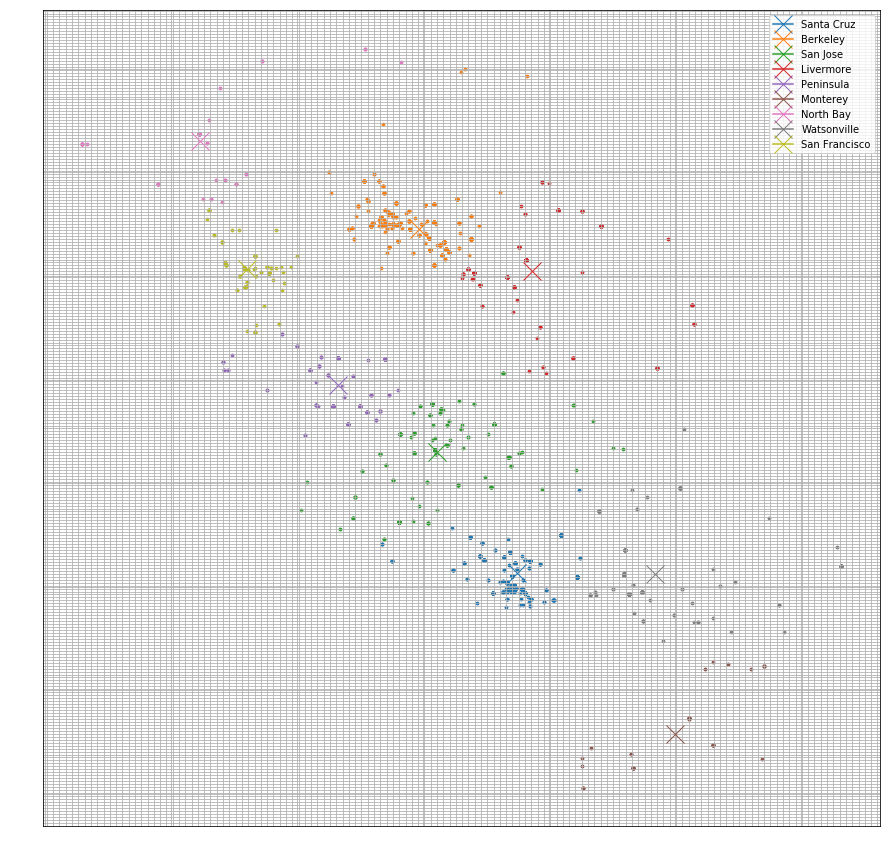

In [719]:
from matplotlib.ticker import MultipleLocator

def create_cluster_plot(mush_df, n=9):
    spacingy = (38.4228 - 36.4557) / 275
    spacingx = (123.2710 - 121.5229) / 175
    minorLocatorx = MultipleLocator(spacingx)
    minorLocatory = MultipleLocator(spacingy)
    
    fig = plt.figure(figsize=(15,15))
    ax = fig.gca()
    ax.yaxis.set_minor_locator(minorLocatory)
    ax.xaxis.set_minor_locator(minorLocatorx)
    ax.grid(which = 'minor')
    
    for i in range(n):
        cluster = mush_df[mush_df['cluster'] == i]
        plt.scatter(cluster['longitude'], cluster['latitude'], s=8, cmap='viridis')
        c = centroids.iloc[i]
        plt.plot(c['long'], c['lat'], marker='x', markersize=18)
        plt.legend(cluster_dict.values())
    plt.grid()
create_cluster_plot(clustered_mush)

# lat_range = (38.4228 - 36.4557) / 275
# long_range = (-123.2710 - -121.5229) / 175

In [632]:
def create_cluster_map(mush_df, n=9):
    fig, ax = plt.subplots(figsize=(15,15))
    x = edible_by_species['longitude']
    y = edible_by_species['latitude']

    for i in range(n):
        cluster = clustered_mush[clustered_mush['cluster']==i]
        plt.scatter(cluster['longitude'], cluster['latitude'], s=10, cmap='viridis')
        c = centroids.iloc[i]
        ax.plot(c['long'], c['lat'], marker='*', markersize=18)

    # plt.legend(cluster_dict.values())
    return mplleaflet.display(fig=fig)
    
create_cluster_map(clustered_mush)

In [720]:
edible_by_species_clustered = pd.concat([edible_by_species, clustered_mush['cluster']],axis=1)
# edible_by_species_clustered = pd.concat([edible_by_species, terrain_df], axis=1)
edible_by_species_clustered.head(10)

id          created_at          text_name   latitude   longitude  \
0  67218  2011-05-11 22:10:54  Agaricus augustus  36.982649 -121.872498   
1  24690  2009-08-24 08:54:47  Agaricus augustus  37.769001 -122.483501   
2  191814 2014-12-05 18:08:54  Agaricus augustus  37.003799 -122.055500   
3  74559  2011-08-24 06:26:43  Agaricus augustus  36.891850 -121.711002   
4  56761  2010-10-26 23:57:43  Agaricus augustus  37.780701 -122.514000   
5  59054  2010-11-17 04:38:29  Agaricus augustus  36.990400 -122.058998   
6  21553  2009-06-02 18:59:21  Agaricus augustus  37.056599 -122.134998   
7  69255  2011-06-15 00:08:04  Agaricus augustus  37.777500 -122.511501   
8  250096 2016-08-29 06:27:47  Agaricus augustus  37.878250 -122.236500   
9  223914 2015-11-27 16:32:51  Agaricus augustus  37.245100 -122.144001   

   is_redwood  is_fir  is_canyon  is_oak grid_code  cluster  
0  0           0       0          0       147_280   7        
1  0           0       0          1       367_157   8        
2  0           0       0          0       153_243   0        
3  0           0       0          0       121_312   7        
4  0           0       0          0       370_151   8        
5  0           0       0          0       149_242   0        
6  0           0       0          0       168_227   0        
7  0           0       0          0       369_152   8        
8  0           0       0          0       397_207   1        
9  0           0       0          0       220_225   2

### Assign weather readings based on cluster number

In [721]:
### SF weather
# weather_1_df=SF, 2=Sonoma, 3=San Jose, 4=Santa Cruz, 5-Livermore, 6=Berkeley, 7-Monterey
# 'Date', 'TMax', 'TMin', 'TAvg', 'TDep', 'HDD', 'CDD', 'Precip', 'station'

# cluster_dict = {
#     0: 'Santa Cruz', 1: 'Berkeley', 2: 'Peninsula', 3: 'San Francisco', 4: 'San Jose',
#     5: 'North Bay', 6: 'Monterey', 7: 'Watsonville', 8: 'Livermore'
# }

def assign_cluster_data(row, col):
    cluster_map = {0:4, 1:1, 2:3, 3:3, 4:2, 5:5, 6:5, 7:3, 8:4, 9:3}
    weather_date_str = str(row['created_at'])[0:10]
    return w_all_df[(w_all_df['Date'] == weather_date_str) & (w_all_df['station'] == cluster_map[row['cluster']])][col].values[0]
    
def assign_station_data(mush_df):
    edible_by_species_clustered_weather['TMax'] = 0
    edible_by_species_clustered_weather['TMin'] = 0
    edible_by_species_clustered_weather['Precip'] = 0

    weather_assign_cols = ['TMax', 'TMin', 'Precip']
    for col in weather_assign_cols:
        mush_df[col] = mush_df.apply(lambda row: assign_cluster_data(row, col), axis=1)

    return mush_df

edible_by_species_clustered_weather = edible_by_species_clustered.copy()
edible_by_species_clustered_weather = assign_station_data(edible_by_species_clustered_weather)
edible_by_species_clustered_weather.head(5)
# edible_by_species_clustered.isnull().sum()

id          created_at          text_name   latitude   longitude  \
0  67218  2011-05-11 22:10:54  Agaricus augustus  36.982649 -121.872498   
1  24690  2009-08-24 08:54:47  Agaricus augustus  37.769001 -122.483501   
2  191814 2014-12-05 18:08:54  Agaricus augustus  37.003799 -122.055500   
3  74559  2011-08-24 06:26:43  Agaricus augustus  36.891850 -121.711002   
4  56761  2010-10-26 23:57:43  Agaricus augustus  37.780701 -122.514000   

   is_redwood  is_fir  is_canyon  is_oak grid_code  cluster TMax TMin Precip  
0  0           0       0          0       147_280   7        64   52   0.00   
1  0           0       0          1       367_157   8        71   56   0.00   
2  0           0       0          0       153_243   0        64   59   0.19   
3  0           0       0          0       121_312   7        84   62   0.00   
4  0           0       0          0       370_151   8        69   42   0.00

### Replace numeric cluster names with meaningful labels

In [722]:
edible_by_species_clustered_weather = edible_by_species_clustered_weather.replace({'cluster': cluster_dict})
edible_by_species_clustered_weather.head(10)

id          created_at          text_name   latitude   longitude  \
0  67218  2011-05-11 22:10:54  Agaricus augustus  36.982649 -121.872498   
1  24690  2009-08-24 08:54:47  Agaricus augustus  37.769001 -122.483501   
2  191814 2014-12-05 18:08:54  Agaricus augustus  37.003799 -122.055500   
3  74559  2011-08-24 06:26:43  Agaricus augustus  36.891850 -121.711002   
4  56761  2010-10-26 23:57:43  Agaricus augustus  37.780701 -122.514000   
5  59054  2010-11-17 04:38:29  Agaricus augustus  36.990400 -122.058998   
6  21553  2009-06-02 18:59:21  Agaricus augustus  37.056599 -122.134998   
7  69255  2011-06-15 00:08:04  Agaricus augustus  37.777500 -122.511501   
8  250096 2016-08-29 06:27:47  Agaricus augustus  37.878250 -122.236500   
9  223914 2015-11-27 16:32:51  Agaricus augustus  37.245100 -122.144001   

   is_redwood  is_fir  is_canyon  is_oak grid_code        cluster TMax TMin  \
0  0           0       0          0       147_280   Watsonville    64   52    
1  0           0       0          1       367_157   San Francisco  71   56    
2  0           0       0          0       153_243   Santa Cruz     64   59    
3  0           0       0          0       121_312   Watsonville    84   62    
4  0           0       0          0       370_151   San Francisco  69   42    
5  0           0       0          0       149_242   Santa Cruz     70   40    
6  0           0       0          0       168_227   Santa Cruz     72   54    
7  0           0       0          0       369_152   San Francisco  75   51    
8  0           0       0          0       397_207   Berkeley       68   56    
9  0           0       0          0       220_225   San Jose       56   35    

  Precip  
0  0.00   
1  0.00   
2  0.19   
3  0.00   
4  0.00   
5  0.00   
6  0.00   
7  0      
8  0.00   
9  0.00

### Export to .csv for Tableau

In [724]:
# edible_by_species_clustered_weather.to_csv('./data/edible_clustered_weather_named.csv', index=False)

### Make train and test sets

In [725]:
### save pre-split train-test grid_code for reassignment after split
train_test_grid_codes = ['grid_code_' + code for code in edible_by_species_clustered_weather['grid_code'].unique()]

edible_clustered_weather_train, edible_clustered_weather_test = get_mushroom_train_test(edible_by_species_clustered_weather, '2016-07-01')
edible_clustered_weather_train.head()

id          created_at          text_name   latitude   longitude  \
0  67218  2011-05-11 22:10:54  Agaricus augustus  36.982649 -121.872498   
1  24690  2009-08-24 08:54:47  Agaricus augustus  37.769001 -122.483501   
2  191814 2014-12-05 18:08:54  Agaricus augustus  37.003799 -122.055500   
3  74559  2011-08-24 06:26:43  Agaricus augustus  36.891850 -121.711002   
4  56761  2010-10-26 23:57:43  Agaricus augustus  37.780701 -122.514000   

   is_redwood  is_fir  is_canyon  is_oak grid_code        cluster TMax TMin  \
0  0           0       0          0       147_280   Watsonville    64   52    
1  0           0       0          1       367_157   San Francisco  71   56    
2  0           0       0          0       153_243   Santa Cruz     64   59    
3  0           0       0          0       121_312   Watsonville    84   62    
4  0           0       0          0       370_151   San Francisco  69   42    

  Precip  
0  0.00   
1  0.00   
2  0.19   
3  0.00   
4  0.00

In [726]:
def make_weather_data_numeric(mush_df):
    # edible_clustered_train['created_at'][0].toordinal()
    mush_df['TMax'] = mush_df['TMax'].astype(int)
    mush_df['TMin'] = mush_df['TMax'].astype(int)
    mush_df['Precip'] = mush_df['Precip'].astype(float)
    
    return mush_df

edible_clustered_weather_train = make_weather_data_numeric(edible_clustered_weather_train)
edible_clustered_weather_train.dtypes

/Users/chris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/chris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/chris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.p

id            int64         
created_at    datetime64[ns]
text_name     object        
latitude      float64       
longitude     float64       
is_redwood    int64         
is_fir        int64         
is_canyon     int64         
is_oak        int64         
grid_code     object        
cluster       object        
TMax          int64         
TMin          int64         
Precip        float64       
dtype: object

### Reassigning temporal data based on month as string and year as continuous

In [727]:
def alter_time_data(mush_df):
    # edible_clustered_weather_train['created_at'] = edible_clustered_train['created_at'].map(lambda x: x.toordinal())
    mush_df['month'] = mush_df['created_at'].map(lambda row: row.month).astype(str)
    mush_df['year'] = mush_df['created_at'].map(lambda row: row.year)
    mush_df = mush_df.drop(['created_at'], axis=1)
    
    return mush_df

edible_clustered_weather_train = alter_time_data(edible_clustered_weather_train)
# edible_clustered_weather_train.dtypes
edible_clustered_weather_train.tail(10)

/Users/chris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/chris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


id                   text_name   latitude   longitude  is_redwood  \
2392  120364  Volvopluteus gloiocephalus  37.424101 -122.268002  0            
2393  186321  Volvopluteus gloiocephalus  37.062550 -122.029499  0            
2394  197020  Volvopluteus gloiocephalus  37.314400 -122.063499  0            
2397  27422   Volvopluteus gloiocephalus  36.982649 -121.872498  0            
2398  33126   Volvopluteus gloiocephalus  37.548901 -122.259499  0            
2399  14821   Volvopluteus gloiocephalus  37.393499 -122.087002  0            
2400  61171   Volvopluteus gloiocephalus  37.551399 -122.334999  0            
2401  228895  Volvopluteus gloiocephalus  37.973549 -121.999001  0            
2402  233434  Volvopluteus gloiocephalus  37.313499 -122.063999  0            
2403  18876   Volvopluteus gloiocephalus  36.990400 -122.058998  0            

      is_fir  is_canyon  is_oak grid_code      cluster  TMax  TMin  Precip  \
2392  0       0          0       270_200   Peninsula    52    52    0.000    
2393  0       0          0       169_248   Santa Cruz   69    69    0.000    
2394  0       0          0       240_241   San Jose     64    64    0.000    
2397  0       0          0       147_280   Watsonville  68    68    0.000    
2398  0       0          0       305_202   Peninsula    55    55    1.260    
2399  0       0          0       262_237   San Jose     65    65    0.001    
2400  0       0          0       306_187   Peninsula    59    59    0.270    
2401  0       0          0       424_254   Livermore    59    59    0.000    
2402  0       0          0       239_241   San Jose     73    73    0.000    
2403  0       0          0       149_242   Santa Cruz   63    63    0.300    

     month  year  
2392  12    2012  
2393  10    2014  
2394  1     2015  
2397  10    2009  
2398  2     2010  
2399  12    2008  
2400  12    2010  
2401  1     2016  
2402  2     2016  
2403  2     2009

In [728]:
# edible_clustered_weather_train['is_canyon'].value_counts()

### Running Several Different Models and SS/PCA Using Pipeline

In [550]:
log_reg = LogisticRegression()
knn_clf = KNeighborsClassifier()
dt_clf = DecisionTreeClassifier()
bag_clf = BaggingClassifier()
rf_clf = RandomForestClassifier()
ada_clf = AdaBoostClassifier()
svc = SVC()
pca = PCA()

# models = {'log_reg': log_reg, 'knn_clf': knn_clf,  'dt_clf': dt_clf, 'bag_clf': bag_clf, 'rf_clf': rf_clf, 'ada_clf': ada_clf, 'svc': svc}
models = {'log_reg': log_reg, 'knn_clf': knn_clf, 'rf_clf': rf_clf, 'svc': svc}

### initialize score dictionary
scores = {}

for model_name, model in models.items():
    pipe = Pipeline(steps=[('ss', ss), ('pca', pca), (model_name, model)])
    feature_importances = ''

    params = {}
    if (model_name) == 'log_reg':
        params['log_reg__penalty'] = ['l1', 'l2']
        params['log_reg__C'] = np.arange(0.05, 0.95, 0.05)
    elif (model_name) == 'knn_clf':
        params['knn_clf__n_neighbors'] = (3, 7, 11, 15)
    elif (model_name) == 'dt_clf':
        params['dt_clf__max_depth'] = [5, 7, 10]
        params['dt_clf__min_samples_split'] = [3, 5, 7, 9]
        params['dt_clf__min_samples_leaf'] = [2, 4, 6, 8]
    elif (model_name) == 'bag_clf':
        params['bag_clf__n_estimators'] = [45, 50, 55]
    elif (model_name) == 'rf_clf':
        params['rf_clf__max_features'] = ['auto', 'sqrt', 'log2']
        params['rf_clf__max_depth'] = [6, 10, 14]
    elif (model_name) == 'ada_clf':
        params['ada_clf__n_estimators'] = [45, 50, 55]
        params['ada_clf__learning_rate'] = [.5, .7, 1.0] 
    elif (model_name) == 'svc':
        params['svc__C'] = np.arange(1, 10, 1)
        params['svc__kernel'] = ['rbf']
        # params['svc__gamma'] = np.arange(0.1, 0.01, .005)
        params['svc__gamma'] = ['auto', 0.01, .1]

    gs = GridSearchCV(pipe, params)
    gs.fit(X_train, y_train)
    train_score = gs.best_score_
    # train_score = gs.score(X_train, y_train)
    # test_score = gs.score(X_test, y_test)
    best_estimator = gs.best_estimator_.steps[2][1]
    best_params = gs.best_params_
    # y_train_pred = best_estimator.predict(X_train)
    # y_test_pred = best_estimator.predict(X_test)
    
    try:
        coefs = best_estimator.coef_.ravel()
    except:
        coefs = ''    
    try:
        feature_importances = best_estimator.feature_importances_
    except:
        if model_name == 'knn_clf':
            skb.fit(X_train, y_train)
            feature_importances = skb.pvalues_
        # elif model_name == 'bag_clf':
        #     sfm = SelectFromModel(bag_reg)
        #     sfm.fit(X_train, y_train)
        #     feature_importances = sfm.get_support(indices=True)        
        else:
            feature_importances = ''
    
    scores[model_name] = {'train_score': train_score, 
                          # 'test_score': test_score, 
                          'best_params': best_params, 
                          'best_estimator': best_estimator,
                          'coefs': coefs,
                          'feature_importances': feature_importances,
                          # 'y_train_pred': y_train_pred,
                          # 'y_test_pred': y_test_pred
                          # 'cv_result': gs.cv_results_
                         }

scores

/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [  8  11  15  16  17  22  24  48  58  59  63  64  70  77  80  81  88  91
  93  99 104 107 108 113 115 120 126 130 131 139 145 169 171 178 182 183
 189 220 234 241 253 255 256 258 263 266 276 277 280] are constant.
  UserWarning)


{'log_reg': {'train_score': 0.24596774193548387,
  'best_params': {'log_reg__C': 0.29999999999999999, 'log_reg__penalty': 'l1'},
  'best_estimator': LogisticRegression(C=0.29999999999999999, class_weight=None, dual=False,
            fit_intercept=True, intercept_scaling=1, max_iter=100,
            multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
            solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
  'coefs': array([ 0.31100944,  0.03731967,  0.14419971, ...,  0.        ,
          0.        ,  0.        ]),
  'feature_importances': ''},
 'knn_clf': {'train_score': 0.18817204301075269,
  'best_params': {'knn_clf__n_neighbors': 3},
  'best_estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=3, p=2,
             weights='uniform'),
  'coefs': '',
  'feature_importances': array([  1.96595233e-03,   1.17154094e-04,   4.65170436e-10,
           9.21059721e-04,   9.21059

In [551]:
pd.set_option('max_colwidth',1000)

model_names = list(scores.keys())
train_score = []
test_score = []
coefs = []
feature_importances = []

for model, score_dict in scores.items():
    train_score.append(score_dict['train_score'])
    # test_score.append(score_dict['test_score'])
    coefs.append(score_dict['coefs'])
    feature_importances.append(score_dict['feature_importances'])

scores_df = pd.DataFrame({'train score': train_score, 'regression model': model_names, 'coefs': coefs, 'best_estimator': best_estimator})
scores_df

best_estimator  \
0  SVC(C=4, cache_size=200, class_weight=None, coef0=0.0,\n  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',\n  max_iter=-1, probability=False, random_state=None, shrinking=True,\n  tol=0.001, verbose=False)   
1  SVC(C=4, cache_size=200, class_weight=None, coef0=0.0,\n  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',\n  max_iter=-1, probability=False, random_state=None, shrinking=True,\n  tol=0.001, verbose=False)   
2  SVC(C=4, cache_size=200, class_weight=None, coef0=0.0,\n  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',\n  max_iter=-1, probability=False, random_state=None, shrinking=True,\n  tol=0.001, verbose=False)   
3  SVC(C=4, cache_size=200, class_weight=None, coef0=0.0,\n  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',\n  max_iter=-1, probability=False, random_state=None, shrinking=True,\n  tol=0.001, verbose=False)   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  coefs  \
0  [0.311009441591, 0.0373196661581, 0.144199707476, 0.0, -0.0645403875978, 0.0702183644693, -0.0649985822273, 0.0, 0.0, 0.0, -0.191053902589, 0.0, 0.0, 0.0, -0.0568610630923, -0.0177331625148, 0.0, 0.16548892659, 0.0174642126242, 0.0, 0.317489692939, 0.0, 0.0, 0.0385969580564, 0.0, 0.0, 0.294695551039, -0.0241899705651, -0.243058191984, 0.347807875184, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.159196137395, 0.0, 0.0, 0.104011661163, 0.0, 0.0, 0.0, 0.0210912590843, 0.173798389665, 0.0, 0.0, -0.0362960790205, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0555089159278, 0.0, 0.233853677493, -0.0944184887165, 0.0, -0.00582812120217, 0.0, -0.129678955635, -0.0112332821244, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0930166858877, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0691336397287, 0.0, 0.0, 0.0, 0.0621969710068, 0.0, -0.00881681065607, 0.0, 0.130753336195, 0.0, 0.0, 0.0, 0.062461766423, 0.0, 0.0, ...]   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2                                                                                                                                                                                                                                                                                               

In [552]:
log_reg = LogisticRegression()
knn_clf = KNeighborsClassifier()
dt_clf = DecisionTreeClassifier()
bag_clf = BaggingClassifier()
rf_clf = RandomForestClassifier()
ada_clf = AdaBoostClassifier()
# svc = SVC()
# pca = PCA()

# models = {'log_reg': log_reg, 'knn_clf': knn_clf,  'dt_clf': dt_clf, 'bag_clf': bag_clf, 'rf_clf': rf_clf, 'ada_clf': ada_clf, 'svc': svc}
models = {'log_reg': log_reg, 'knn_clf': knn_clf, 'rf_clf': rf_clf}

### initialize score dictionary
scores2 = {}

for model_name, model in models.items():
    pipe = Pipeline(steps=[(model_name, model)])
    feature_importances = ''

    params = {}
    if (model_name) == 'log_reg':
        params['log_reg__penalty'] = ['l1', 'l2']
        params['log_reg__C'] = np.arange(0.05, 0.95, 0.05)
    elif (model_name) == 'knn_clf':
        params['knn_clf__n_neighbors'] = (3, 7, 11, 15)
    elif (model_name) == 'dt_clf':
        params['dt_clf__max_depth'] = [5, 7, 10]
        params['dt_clf__min_samples_split'] = [3, 5, 7, 9]
        params['dt_clf__min_samples_leaf'] = [2, 4, 6, 8]
    elif (model_name) == 'bag_clf':
        params['bag_clf__n_estimators'] = [45, 50, 55]
    elif (model_name) == 'rf_clf':
        params['rf_clf__max_features'] = ['auto', 'sqrt', 'log2']
        params['rf_clf__max_depth'] = [6, 10, 14]
    elif (model_name) == 'ada_clf':
        params['ada_clf__n_estimators'] = [45, 50, 55]
        params['ada_clf__learning_rate'] = [.5, .7, 1.0] 
    elif (model_name) == 'svc':
        params['svc__C'] = np.arange(1, 10, 1)
        params['svc__kernel'] = ['rbf', 'poly']
        # params['svc__gamma'] = np.arange(0.1, 0.01, .005)
        params['svc__gamma'] = ['auto', 0.01, .1]

    gs = GridSearchCV(pipe, params)
    gs.fit(X_train, y_train)
    train_score = gs.best_score_
    # train_score = gs.score(X_train, y_train)
    # test_score = gs.score(X_test, y_test)
    best_estimator = gs.best_estimator_.steps[0][1]
    best_params = gs.best_params_
    # y_train_pred = best_estimator.predict(X_train)
    # y_test_pred = best_estimator.predict(X_test)
    
    try:
        coefs = best_estimator.coef_.ravel()
    except:
        coefs = ''    
    try:
        feature_importances = best_estimator.feature_importances_
    except:
        if model_name == 'knn_clf':
            skb.fit(X_train, y_train)
            feature_importances = skb.pvalues_
        # elif model_name == 'bag_clf':
        #     sfm = SelectFromModel(bag_reg)
        #     sfm.fit(X_train, y_train)
        #     feature_importances = sfm.get_support(indices=True)        
        else:
            feature_importances = ''
    
    scores2[model_name] = {'train_score': train_score, 
                          # 'test_score': test_score, 
                          'best_params': best_params, 
                          'best_estimator': best_estimator,
                          'coefs': coefs,
                          'feature_importances': feature_importances,
                          # 'y_train_pred': y_train_pred,
                          # 'y_test_pred': y_test_pred
                          # 'cv_result': gs.cv_results_
                         }

scores2

/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [  8  11  15  16  17  22  24  48  58  59  63  64  70  77  80  81  88  91
  93  99 104 107 108 113 115 120 126 130 131 139 145 169 171 178 182 183
 189 220 234 241 253 255 256 258 263 266 276 277 280] are constant.
  UserWarning)


{'log_reg': {'train_score': 0.24059139784946237,
  'best_params': {'log_reg__C': 0.75000000000000011, 'log_reg__penalty': 'l1'},
  'best_estimator': LogisticRegression(C=0.75000000000000011, class_weight=None, dual=False,
            fit_intercept=True, intercept_scaling=1, max_iter=100,
            multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
            solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
  'coefs': array([ 0.23745491,  1.45284088,  0.        , ...,  0.        ,
          0.        ,  0.        ]),
  'feature_importances': ''},
 'knn_clf': {'train_score': 0.1196236559139785,
  'best_params': {'knn_clf__n_neighbors': 3},
  'best_estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=3, p=2,
             weights='uniform'),
  'coefs': '',
  'feature_importances': array([  1.96595233e-03,   1.17154094e-04,   4.65170436e-10,
           9.21059721e-04,   9.210597

In [553]:
pd.set_option('max_colwidth', 1000)

model_names = list(scores2.keys())
train_score = []
test_score = []
coefs = []
feature_importances = []

for model, score_dict2 in scores2.items():
    train_score.append(score_dict2['train_score'])
    # test_score.append(score_dict['test_score'])
    coefs.append(score_dict2['coefs'])
    feature_importances.append(score_dict2['feature_importances'])

scores2_df = pd.DataFrame({'train score': train_score, 'regression model': model_names, 'coefs': coefs, 'feature importances': feature_importances})
scores2_df

coefs  \
0  [0.237454905879, 1.45284087836, 0.0, 0.0, -0.029213995587, 0.0, -0.000941490743139, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.38053792845, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.6929306468, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.323516108423, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       feature importances  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
1  [0.00196595233255, 0.000117154094357, 4.65170436497e-10, 0.000921059721342, 0.000921059721342, 0.484802489588, 0.0371283380596, 0.953998886105, nan, 0.660295604463, 0.953998886105, nan, 0.896852442439, 0.6

### Adding LabelEncoder

In [868]:
label_enc = LabelEncoder()

def get_labels(le):
    return le.classes_

def decode_labels(le, labelled_series):
    decoded = le.inverse_transform(labelled_series)
    return decoded

### Running LogisticRegression and PCA

In [869]:
pca = PCA()

X = edible_by_species_clustered_weather.copy()
y = label_enc.fit_transform(X['text_name'])

X = make_weather_data_numeric(X)
X = alter_time_data(X)
X = X.drop(['id', 'latitude', 'longitude', 'text_name', 'cluster'], axis=1)
X = pd.get_dummies(X, columns=['grid_code', 'month'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=314)

log_reg = LogisticRegression(C=0.75, penalty='l1')
log_reg.fit_transform(X_train, y_train)
log_reg.score(X_train, y_train)
log_reg_preds = log_reg.predict(X_test)
log_reg_preds

X_train_ss = ss.fit_transform(X_train)
pca.fit(X_train_ss)
X_train_ss_pca = pca.transform(X_train_ss)
log_reg.fit_transform(X_train_ss_pca, y_train)
cross_val_score(log_reg, X_train_ss_pca, y_train), cross_val_score(log_reg, X_train_ss_pca, y_train)

/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has 

(array([ 0.15679443,  0.16994633,  0.16029144]),
 array([ 0.15679443,  0.16994633,  0.16029144]))

In [872]:
X_test_ss = ss.transform(X_test)
pca.transform(X_test_ss)

y_preds_lr = log_reg.predict(X_test_ss)
y_preds_lr = label_enc.inverse_transform(y_preds_lr)
len(y_preds_lr), y_preds_lr[0:10]

(722, array(['Clitocybe nuda', 'Pleurotus ostreatus', 'Entoloma medianox',
        'Pleurotus ostreatus', 'Cantharellus californicus',
        'Amanita calyptroderma', 'Suillus fuscotomentosus',
        'Entoloma medianox', 'Pleurotus ostreatus', 'Coprinus comatus'], dtype=object))

In [873]:
mush_labels = get_labels(label_enc)
print(mush_labels)

['Agaricus augustus' 'Agaricus subrutilescens' 'Amanita augusta'
 'Amanita calyptroderma' 'Amanita novinupta' 'Amanita vaginata'
 'Amanita velosa' 'Armillaria mellea' 'Boletus edulis' 'Boletus regineus'
 'Cantharellus californicus' 'Chlorophyllum brunneum' 'Clavaria fragilis'
 'Clitocybe nuda' 'Coprinellus micaceus' 'Coprinus comatus'
 'Entoloma medianox' 'Flammulina velutipes' 'Gliophorus psittacinus'
 'Gomphidius oregonensis' 'Gymnopus dryophilus' 'Hericium erinaceus'
 'Hydnum repandum' 'Laccaria amethysteo-occidentalis'
 'Lacrymaria lacrymabunda' 'Lactarius deliciosus' 'Lactarius rubidus'
 'Lactarius rufulus' 'Laetiporus gilbertsonii' 'Leccinum manzanitae'
 'Lentinula edodes' 'Panaeolus papilionaceus' 'Pleurotus ostreatus'
 'Pluteus cervinus' 'Suillus fuscotomentosus' 'Suillus pungens'
 'Volvopluteus gloiocephalus']


In [732]:
# cm_y_test = label_enc.inverse_transform(y_test)
# cm_y_preds = label_enc.inverse_transform(y_preds_lr)
# labels = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p']
# pca_cm = confusion_matrix(label_enc.inverse_transform(y_test), y_preds_lr)

# fig, axis = plt.subplots(1, 1, figsize=(15, 15))
# sns.heatmap(pca_cm, square=True, cmap='inferno')

In [874]:
total = pca_cm.sum(axis=None)
correct = pca_cm.diagonal().sum()
print("PCA Accuracy: %0.2f %%" % (100.0 * correct/total))

PCA Accuracy: 25.00 %


### Trying predict_proba()

In [927]:
probas = log_reg.predict_proba(X_test_ss)
probas_df = pd.DataFrame(probas, index=X_test.index)
probas_df.columns = mush_labels
probas_df

Agaricus augustus  Agaricus subrutilescens  Amanita augusta  \
2074  0.018939           0.014788                 3.196887e-02      
1119  0.038300           0.017339                 4.138788e-02      
2003  0.007998           0.005964                 6.481642e-03      
1945  0.070170           0.020619                 1.784748e-02      
226   0.021971           0.014294                 2.795084e-02      
1536  0.062004           0.050497                 3.519561e-02      
50    0.023715           0.014833                 3.540630e-02      
1220  0.005759           0.006717                 8.908804e-03      
1940  0.027336           0.016236                 3.310786e-02      
880   0.030130           0.013513                 2.388877e-02      
349   0.011087           0.001237                 2.039764e-02      
802   0.008599           0.009109                 1.743418e-02      
579   0.001969           0.309532                 4.840175e-03      
1597  0.005069           0.052456                 6.307315e-02      
452   0.010544           0.024232                 7.016218e-02      
1130  0.019334           0.015482                 1.987483e-02      
1963  0.017670           0.014333                 3.098496e-02      
691   0.042271           0.013263                 5.405330e-02      
1454  0.009042           0.007997                 2.906061e-03      
2168  0.041336           0.015907                 3.326998e-02      
393   0.086691           0.023097                 4.116106e-02      
461   0.025119           0.017718                 1.662219e-02      
244   0.000311           0.017291                 2.406851e-02      
719   0.009178           0.008427                 1.366732e-02      
873   0.009042           0.007997                 2.906061e-03      
2370  0.017983           0.013336                 2.567958e-02      
1226  0.007676           0.008292                 9.636508e-03      
1511  0.033025           0.017215                 1.040503e-01      
603   0.021853           0.013245                 2.914686e-03      
1300  0.076868           0.006223                 5.080321e-03      
...        ...                ...                          ...      
164   0.051707           0.023490                 1.317770e-02      
1251  0.077669           0.022717                 3.237708e-02      
2071  0.002961           0.028812                 1.022917e-02      
1266  0.009377           0.002300                 9.159608e-02      
138   0.046426           0.013875                 6.787001e-02      
1195  0.082097           0.022302                 3.845759e-02      
2245  0.001322           0.002049                 4.537220e-03      
1073  0.031129           0.016720                 3.674842e-02      
1514  0.000112           0.098330                 5.937010e-09      
1433  0.035087           0.016095                 8.585728e-02      
481   0.005892           0.007690                 1.183956e-02      
1516  0.000801           0.000714                 3.852603e-04      
2271  0.010213           0.007058                 1.428296e-02      
75    0.032357           0.014479                 2.881790e-02      
1530  0.007408           0.000674                 1.147101e-02      
382   0.026868           0.013422                 2.379257e-02      
1542  0.000252           0.011328                 1.847162e-02      
899   0.008157           0.011736                 4.023098e-02      
966   0.017933           0.015476                 3.104175e-02      
1889  0.030501           0.014517                 2.556327e-02      
635   0.013837           0.007574                 1.410896e-02      
2027  0.001503           0.000114                 5.551415e-06      
1194  0.022053           0.015403                 3.275303e-02      
2226  0.020423           0.014553                 2.993841e-02      
1453  0.025863           0.016330                 3.589075e-02      
1466  0.002953           0.039094                 3.558039e-02      
748 

In [928]:
for index, row in probas_df.head().iterrows():
    three_prob = row.nlargest(3)
    print(three_prob.index)

    # return ",".join(three_prob)
    # print(",".join(three_prob))

Index(['Clitocybe nuda', 'Entoloma medianox', 'Cantharellus californicus'], dtype='object')
Index(['Pleurotus ostreatus', 'Lactarius rubidus', 'Boletus edulis'], dtype='object')
Index(['Entoloma medianox', 'Boletus regineus', 'Cantharellus californicus'], dtype='object')
Index(['Pleurotus ostreatus', 'Gymnopus dryophilus', 'Amanita calyptroderma'], dtype='object')
Index(['Cantharellus californicus', 'Clitocybe nuda', 'Pleurotus ostreatus'], dtype='object')


In [929]:
# probas_df.head()
def find_highest_probs(row):
    # print(row.nlargest(3))
    three_prob = row.nlargest(5)
    # print(three_prob.index)
    # print(list(three_prob))
    # print(",".join(list(three_prob.index)))
    return ",".join(list(three_prob.index))
    
probas_df['three_prob'] = probas_df.T.apply(find_highest_probs)
probas_df.head()

Agaricus augustus  Agaricus subrutilescens  Amanita augusta  \
2074  0.018939           0.014788                 0.031969          
1119  0.038300           0.017339                 0.041388          
2003  0.007998           0.005964                 0.006482          
1945  0.070170           0.020619                 0.017847          
226   0.021971           0.014294                 0.027951          

      Amanita calyptroderma  Amanita novinupta  Amanita vaginata  \
2074  0.034821               0.051128           0.007796           
1119  0.031947               0.053006           0.008010           
2003  0.038433               0.038611           0.003750           
1945  0.104956               0.001222           0.003600           
226   0.043014               0.039264           0.008590           

      Amanita velosa  Armillaria mellea  Boletus edulis  Boletus regineus  \
2074  0.071201        0.025046           0.024340        0.007485           
1119  0.022455        0.018969           0.076486        0.004502           
2003  0.029388        0.007149           0.002498        0.081671           
1945  0.000451        0.005517           0.073612        0.024306           
226   0.052995        0.017287           0.036568        0.013779           

      Cantharellus californicus  Chlorophyllum brunneum  Clavaria fragilis  \
2074  0.078511                   0.014813                0.023303            
1119  0.004725                   0.024642                0.028728            
2003  0.068351                   0.007537                0.007991            
1945  0.022183                   0.023426                0.010635            
226   0.084158                   0.015824                0.021432            

      Clitocybe nuda  Coprinellus micaceus  Coprinus comatus  \
2074  0.085812        0.018546              0.022103           
1119  0.034209        0.020951              0.047212           
2003  0.032527        0.008723              0.011893           
1945  0.017432        0.019942              0.029776           
226   0.077621        0.019888              0.026291           

      Entoloma medianox  Flammulina velutipes  Gliophorus psittacinus  \
2074  0.083502           0.007730              0.018072                 
1119  0.027433           0.011366              0.025170                 
2003  0.370951           0.003160              0.061982                 
1945  0.016521           0.004325              0.004607                 
226   0.048316           0.007295              0.024799                 

      Gomphidius oregonensis  Gymnopus dryophilus  Hericium erinaceus  \
2074  0.020004                0.012116             0.007871             
1119  0.030750                0.012562             0.015392             
2003  0.011815                0.007367             0.004340             
1945  0.034168                0.132207             0.014325             
226   0.028158                0.015523             0.007606             

      Hydnum repandum  Laccaria amethysteo-occidentalis  \
2074  0.003430         0.023967                           
1119  0.003893         0.016053                           
2003  0.001444         0.011705                           
1945  0.002099         0.026054                           
226   0.003424         0.023862                           

      Lacrymaria lacrymabunda  Lactarius deliciosus  Lactarius rubidus  \
2074  0.007766                 0.004946              0.065046            
1119  0.010409                 0.017200              0.080595            
2003  0.004477                 0.002672              0.014957            
1945  0.014494                 0.012634              0.008242            
226   0.009269                 0.004936              0.059387            

      Lactarius rufulus  Laetiporus gilbertsonii  Leccinum manzanitae  \
2074  0.023138           0.004839                 0.016708              
1119  0.006397           0.040355        

In [930]:
# X_test[['year', 'is_redwood']]
y_test_lr = decode_labels(label_enc, y_test)
y_test_lr[0:20]

array(['Pleurotus ostreatus', 'Coprinus comatus',
       'Panaeolus papilionaceus', 'Panaeolus papilionaceus',
       'Amanita calyptroderma', 'Laccaria amethysteo-occidentalis',
       'Agaricus augustus', 'Entoloma medianox', 'Panaeolus papilionaceus',
       'Chlorophyllum brunneum', 'Amanita novinupta',
       'Cantharellus californicus', 'Boletus edulis',
       'Lacrymaria lacrymabunda', 'Amanita velosa', 'Coprinus comatus',
       'Panaeolus papilionaceus', 'Boletus regineus', 'Hericium erinaceus',
       'Pluteus cervinus'], dtype=object)

In [931]:
X_test[['year', 'is_redwood']].head(2)

year  is_redwood
2074  2016  0         
1119  2007  0

In [932]:
# X_c = edible_by_species_clustered_weather.copy()
X_c = X_test[['year', 'is_redwood']]
# X_c = X_test_ss[X_test_ss['id']]
# X_c = pd.concat(X_c, pd.Series(y_test_lr, name='Predictions'))
# X_c = pd.concat([X_c, pd.Series(y_test_lr, name='Predictions')], axis=1)
X_c['predictions'] = pd.Series(y_test_lr, index=X_c.index)
X_c['three_prob'] = pd.Series(probas_df['three_prob'], index=X_c.index)
X_c.head(10)

# X_test_ss['three_prob'] = probas_df['three_prob']
# X_test_ss_c.head()

/Users/chris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/chris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


year  is_redwood                       predictions  \
2074  2016  0           Pleurotus ostreatus                
1119  2007  0           Coprinus comatus                   
2003  2014  0           Panaeolus papilionaceus            
1945  2010  0           Panaeolus papilionaceus            
226   2016  0           Amanita calyptroderma              
1536  2017  0           Laccaria amethysteo-occidentalis   
50    2011  0           Agaricus augustus                  
1220  2015  0           Entoloma medianox                  
1940  2010  0           Panaeolus papilionaceus            
880   2010  0           Chlorophyllum brunneum             

                                                                                                       three_prob  
2074  Clitocybe nuda,Entoloma medianox,Cantharellus californicus,Amanita velosa,Lactarius rubidus                  
1119  Pleurotus ostreatus,Lactarius rubidus,Boletus edulis,Amanita novinupta,Coprinus comatus                      
2003  Entoloma medianox,Boletus regineus,Cantharellus californicus,Suillus fuscotomentosus,Gliophorus psittacinus  
1945  Pleurotus ostreatus,Gymnopus dryophilus,Amanita calyptroderma,Boletus edulis,Agaricus augustus               
226   Cantharellus californicus,Clitocybe nuda,Pleurotus ostreatus,Lactarius rubidus,Amanita velosa                
1536  Amanita calyptroderma,Pleurotus ostreatus,Cantharellus californicus,Boletus edulis,Agaricus augustus         
50    Suillus fuscotomentosus,Cantharellus californicus,Pleurotus ostreatus,Clitocybe nuda,Lactarius rubidus       
1220  Entoloma medianox,Gliophorus psittacinus,Amanita novinupta,Cantharellus californicus,Amanita velosa          
1940  Pleurotus ostreatus,Lactarius rubidus,Boletus edulis,Pluteus cervinus,Entoloma medianox                      
880   Coprinus comatus,Suillus fuscotomentosus,Pleurotus ostreatus,Cantharellus californicus,Clitocybe nuda

In [934]:
my_list = []
for index, row in X_c.iterrows():
    if row['predictions'] in row['three_prob']:
        my_list.append(row)

pd.DataFrame(my_list)

year  is_redwood                       predictions  \
1119  2007  0           Coprinus comatus                   
1220  2015  0           Entoloma medianox                  
349   2013  0           Amanita novinupta                  
452   2010  0           Amanita velosa                     
2168  2008  0           Pluteus cervinus                   
1511  2008  0           Laccaria amethysteo-occidentalis   
2127  2018  0           Pleurotus ostreatus                
248   2010  0           Amanita calyptroderma              
436   2015  0           Amanita velosa                     
796   2015  0           Cantharellus californicus          
2104  2006  0           Pleurotus ostreatus                
139   2010  0           Amanita augusta                    
1498  2013  0           Laccaria amethysteo-occidentalis   
2108  2015  0           Pleurotus ostreatus                
1894  2012  0           Clitocybe nuda                     
1903  2011  0           Clitocybe nuda                     
973   2016  0           Clitocybe nuda                     
593   2010  0           Boletus edulis                     
271   2014  0           Amanita calyptroderma              
645   2011  0           Boletus edulis                     
742   2017  0           Cantharellus californicus          
2260  2014  0           Suillus pungens                    
756   2014  0           Cantharellus californicus          
793   2010  1           Cantharellus californicus          
2182  2010  0           Pluteus cervinus                   
1006  2016  1           Clitocybe nuda                     
979   2012  0           Clitocybe nuda                     
2358  2016  0           Volvopluteus gloiocephalus         
2015  2016  0           Panaeolus papilionaceus            
1132  2010  0           Coprinus comatus                   
...    ... ..                        ...                   
1707  2010  1           Lactarius rubidus                  
2036  2009  0           Pleurotus ostreatus                
276   2010  0           Amanita calyptroderma              
258   2015  1           Amanita calyptroderma              
1519  2010  0           Laccaria amethysteo-occidentalis   
1659  2010  0           Lactarius rubidus                  
2308  2011  0           Suillus pungens                    
2068  2006  0           Pleurotus ostreatus                
598   2012  0           Boletus edulis                     
2099  2009  0           Pleurotus ostreatus                
1632  2016  1           Lactarius rubidus                  
1648  2017  0           Lactarius rubidus                  
1826  2009  0           Laetiporus gilbertsonii            
286   2009  0           Amanita calyptroderma              
1270  2014  1           Gliophorus psittacinus             
344   2016  1           Amanita novinupta                  
535   2018  0           Amanita velosa                     
783   2017  0           Cantharellus californicus          
2381  2006  0           Volvopluteus gloiocephalus         
1000  2017  0           Clitocybe nuda                     
2188  2009  0           Pluteus cervinus                   
1025  2017  0           Clitocybe nuda                     
468   2015  0           Amanita velosa                     
1676  2010  0           Lactarius rubidus                  
1666  2015  1           Lactarius rubidus                  
1266  2016  0           Gliophorus psittacinus             
138   2006  0           Amanita augusta                    
481   2013  0           Amanita velosa                     
748   2012  0           Cantharellus californicus          
1642  2014  0           Lactarius rubidus                  

                                                                                                                 three_prob  
1119  Pleurotus ostreatus,Lactarius rubidus,Boletus edulis,Amanita novinupta,Coprinus comatus                                
1220  Entoloma medianox,Gliophoru

### Running RandomForestClassifier and PCA

In [569]:
X = edible_by_species_clustered_weather.copy()
text_name_dist = X['text_name'].value_counts()
text_name_dist_df = pd.DataFrame(text_name_dist)
text_name_dist_df, len(text_name_dist_df)

(                           text_name
 Clitocybe nuda                   148
 Cantharellus californicus        115
 Lactarius rubidus                107
 Boletus edulis                   104
 Amanita novinupta                 85
 Chlorophyllum brunneum            78
 Entoloma medianox                 73
 Coprinus comatus                  72
 Leccinum manzanitae               51
 Lactarius rufulus                 42
 Coprinellus micaceus              39
 Boletus regineus                  38
 Agaricus subrutilescens           38
 Hericium erinaceus                35
 Lactarius deliciosus              20
 Flammulina velutipes              17
 Lentinula edodes                   2, 17)

In [570]:
label_enc = LabelEncoder()

In [571]:
pca = PCA()

X = edible_by_species_clustered_weather.copy()
y = label_enc.fit_transform(X['text_name'])

X = make_weather_data_numeric(X)
X = alter_time_data(X)
X = X.drop(['id', 'latitude', 'longitude', 'text_name', 'cluster'], axis=1)
X = pd.get_dummies(X, columns=['grid_code', 'month'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=314)

rfc = RandomForestClassifier(max_depth=50, max_features='sqrt')
# rfc.fit_transform(X_train, y_train)
# rfc.score(X_train, y_train)
# rf_preds = rfc.predict(X_test)
# rf_preds

X_train_ss = ss.fit_transform(X_train)
pca.fit(X_train_ss)
X_train_ss_pca = pca.transform(X_train_ss)
rfc.fit_transform(X_train_ss_pca, y_train)
cross_val_score(rfc, X_train_ss_pca, y_train), cross_val_score(rfc, X_train_ss_pca, y_train)

/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


(array([ 0.2007874 ,  0.19758065,  0.2231405 ]),
 array([ 0.19291339,  0.20564516,  0.19008264]))

In [572]:
X_test.shape, y_test.shape
# y_train.isnull().sum(), y_test.isnull().sum()

((320, 295), (320,))

In [643]:
y_test

array([ 6, 13, 10, 10,  5,  6,  6,  1,  5,  4,  8,  3, 13,  6,  6,  6,  3,
        5,  5, 11,  4,  6, 14, 11, 15,  9,  4, 12,  9,  8, 13, 13, 13, 11,
       13,  8,  1,  6,  6,  2,  9, 13, 15, 13, 15,  4, 14,  6,  6,  4,  9,
        4,  4,  6,  1,  5,  1,  2,  8,  5,  2,  6,  1,  5,  1,  4,  1,  2,
        6,  6, 15, 14, 13,  5,  7, 12,  7,  1,  0,  6,  6,  2,  9,  6, 12,
        4,  6, 14,  9,  4,  6, 12,  2,  7,  3, 11, 15, 12,  3,  4,  1,  5,
        4,  9,  1,  7,  2, 14,  6,  1,  8,  5, 13,  1, 15,  4,  9, 13, 13,
        6,  5, 15,  3, 13, 14,  4,  2,  0, 13,  7,  6,  8,  1,  6,  6,  6,
       15,  6,  8,  4,  2, 15,  8,  6, 13, 15,  0,  1,  4,  5,  4, 10,  6,
        5,  8,  1,  0,  2,  5,  6,  2, 13,  2, 14,  3,  2,  4,  4,  4, 10,
        4,  9,  4,  8,  1,  4,  4,  6,  4,  1,  6,  6, 15,  6, 14, 15,  4,
        4,  6,  2,  4,  8,  3,  3,  5, 13,  1,  1,  6, 12,  7,  4,  6,  2,
       11,  5, 13,  5, 11,  6, 11, 13, 13,  8,  9,  2,  4,  5,  2,  6,  1,
        4,  4,  6,  9, 12

### Decode target labels

In [746]:
X_test_ss = ss.transform(X_test)
pca.transform(X_test_ss)

y_preds_rf = rfc.predict(X_test_ss)
# y_preds_rf = label_enc.inverse_transform(y_preds_rf)
y_preds_rf = decode_labels(label_enc, y_preds_rf)
y_preds_rf

ValueError: Number of features of the model must match the input. Model n_features is 295 and input n_features is 395 

In [574]:
# rf_results = pd.DataFrame([y_test, y_preds])
# rf_results_T = rf_results.T
#
# rf_results_T.isnull().sum()
# rf_results

# y_preds_rf[0:100]
# print(label_enc.inverse_transform(y_preds))

rf_results = pd.DataFrame([y_preds_rf])
rf_results.T[0].value_counts(), asd

(Amanita novinupta    301
 Clitocybe nuda        19
 Name: 0, dtype: int64,                                   text_name
 Clitocybe nuda                          148
 Amanita velosa                          140
 Pleurotus ostreatus                     120
 Cantharellus californicus               115
 Amanita calyptroderma                   113
 Lactarius rubidus                       107
 Boletus edulis                          104
 Amanita novinupta                        85
 Panaeolus papilionaceus                  84
 Suillus pungens                          83
 Pluteus cervinus                         82
 Chlorophyllum brunneum                   78
 Gliophorus psittacinus                   78
 Agaricus augustus                        75
 Laccaria amethysteo-occidentalis         74
 Entoloma medianox                        73
 Coprinus comatus                         72
 Amanita augusta                          69
 Laetiporus gilbertsonii                  63
 Volvopluteus gloiocephal

In [676]:
# pca_cm = confusion_matrix(label_enc.inverse_transform(y_test), y_preds_rf, labels)

# fig, axis = plt.subplots(1, 1, figsize=(15, 15))
# sns.heatmap(pca_cm, square=True, cmap='inferno')

In [677]:
# total = pca_cm.sum(axis=None)
# correct = pca_cm.diagonal().sum()
# print("PCA Accuracy: %0.2f %%" % (100.0 * correct/total))

In [679]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

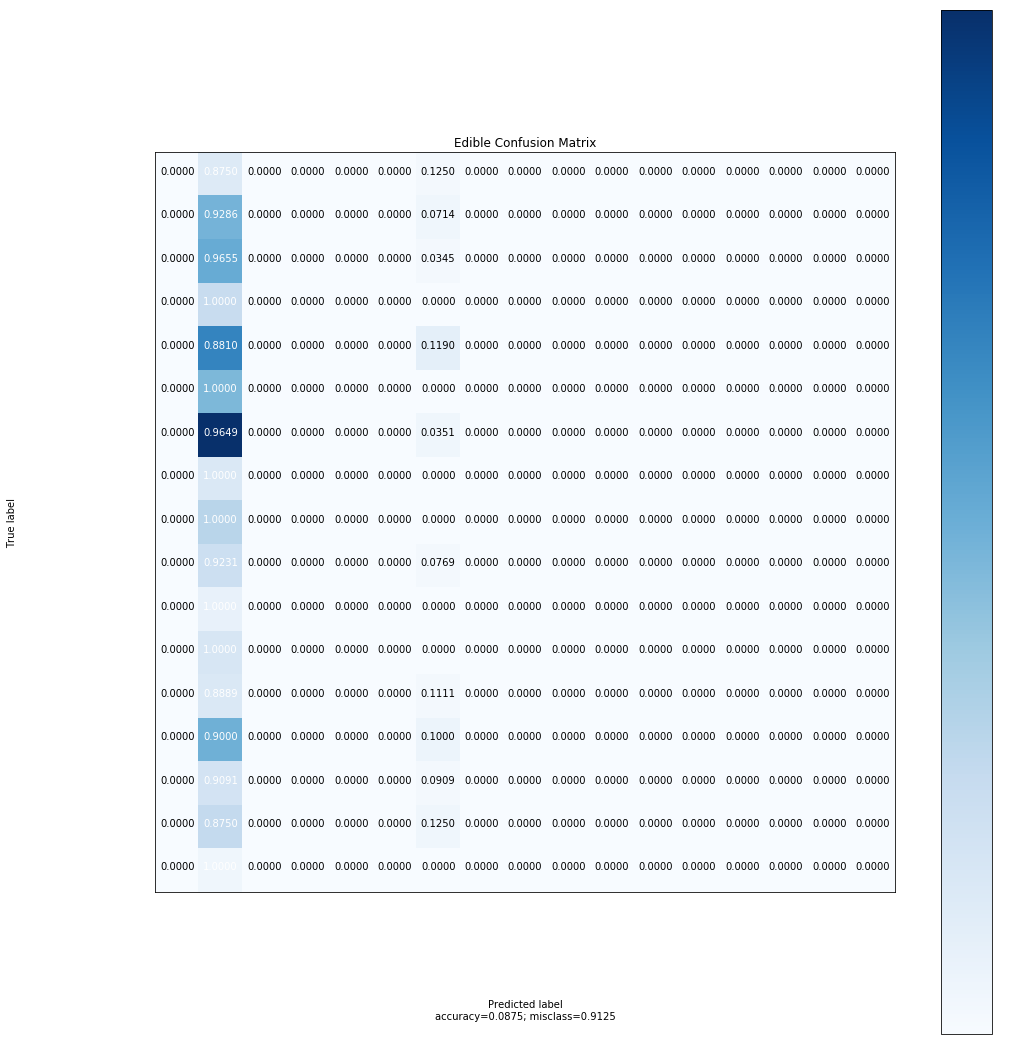

In [680]:
plot_confusion_matrix(pca_cm, labels, title='Edible Confusion Matrix')

In [481]:
X_test['actual'] = y_test
X_test['preds'] = y_preds_rf
X_test[['year', 'actual', 'preds']]

i, j = 0, 0
for index, row in X_test.iterrows():
    if row['actual'] == row['preds']:
        # print(row['actual'], "/", row['preds'])
        j += 1
    i += 1
    
# print(j, '/', i)
X_test['preds'].value_counts(), asd

/Users/chris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/chris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


(Boletus edulis             225
 Clitocybe nuda              80
 Amanita novinupta            7
 Entoloma medianox            6
 Agaricus subrutilescens      1
 Chlorophyllum brunneum       1
 Name: preds, dtype: int64,                                   text_name
 Clitocybe nuda                          148
 Amanita velosa                          140
 Pleurotus ostreatus                     120
 Cantharellus californicus               115
 Amanita calyptroderma                   113
 Lactarius rubidus                       107
 Boletus edulis                          104
 Amanita novinupta                        85
 Panaeolus papilionaceus                  84
 Suillus pungens                          83
 Pluteus cervinus                         82
 Chlorophyllum brunneum                   78
 Gliophorus psittacinus                   78
 Agaricus augustus                        75
 Laccaria amethysteo-occidentalis         74
 Entoloma medianox                        73
 Coprinus comatu

### Running SVC with SS/PCA

In [482]:
svc = SVC()
pca = PCA()

X = edible_by_species_clustered_weather.copy()
y = label_enc.fit_transform(X['text_name'])
X = make_weather_data_numeric(X)
X = alter_time_data(X)
X = X.drop(['id', 'latitude', 'longitude', 'text_name', 'cluster'], axis=1)
X = pd.get_dummies(X, columns=['grid_code', 'month'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=314)

X_train_ss = ss.fit_transform(X_train)
pca.fit(X_train_ss)
X_train_ss_pca = pca.transform(X_train_ss)

svc = SVC(C=9.0, kernel='rbf', gamma='auto')
svc.fit(X_train_ss_pca, y_train)

SVC(C=9.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [483]:
X_train.shape, X_train_ss_pca.shape, X_test.shape

((744, 294), (744, 294), (320, 294))

In [484]:
X_test_ss = ss.transform(X_test)
X_test_ss_pca = pca.transform(X_test_ss)

y_preds_svc = svc.predict(X_test_ss_pca)
y_preds_svc[0:10]

array([ 4,  6,  2, 13,  5,  6,  6,  1,  7,  4])

In [487]:
# X_test['actual'] = label_enc.inverse_transform(y_test)
# X_test['preds'] = label_enc.inverse_transform(y_preds_svc)
# X_test[['year', 'actual', 'preds']]

# i, j = 0, 0
# for index, row in X_test.iterrows():
#     if row['actual'] == row['preds']:
#         print(row['actual'], "/", row['preds'])
#         j += 1
#     i += 1
    
# print(j, '/', i)

# svc.score(X_train_ss_pca, y_train), svc.score(X_test_ss_pca, y_test)
cross_val_score(svc, X_train_ss_pca, y_train), cross_val_score(svc, X_test_ss_pca, y_test)

/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


(array([ 0.23228346,  0.23790323,  0.26446281]),
 array([ 0.20353982,  0.16037736,  0.18811881]))

In [681]:
# pca_cm = confusion_matrix(label_enc.inverse_transform(y_test), label_enc.inverse_transform(y_preds_svc))

# fig, axis = plt.subplots(1, 1, figsize=(15, 15), squeeze=False)
# sns.heatmap(pca_cm, square=True, cmap='inferno')
# axis[0, 0].title('Confusion Matrix:\n2-Component PCA + SVC')
# ylabel('True')
# xlabel('Predicted')
# show()

In [682]:
# total = pca_cm.sum(axis=None)
# correct = pca_cm.diagonal().sum()
# print("PCA Accuracy: %0.2f %%" % (100.0 * correct/total))

PCA Accuracy: 8.75 %


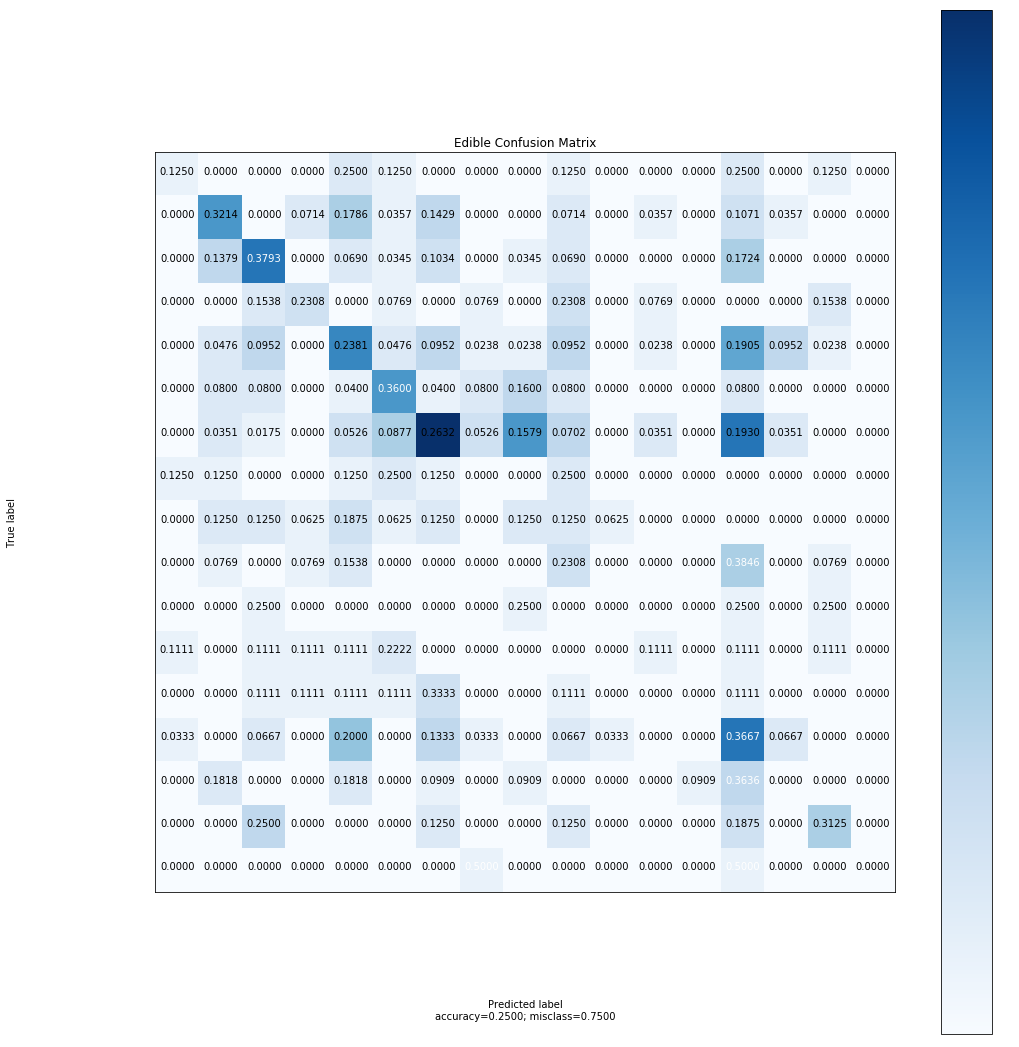

In [686]:
pca_cm = confusion_matrix(label_enc.inverse_transform(y_test), label_enc.inverse_transform(y_preds_svc))
plot_confusion_matrix(pca_cm, labels, title='Edible Confusion Matrix')

### Visualizations

In [ ]:
def mushroom_count_by_year(species_list):
    species_input = '|'.join(species_list)
    # return species_input
    query = "SELECT bay_area_names.text_name, count(bay_area_observations.id) AS name_count, bay_area_observations.created_at, YEAR(bay_area_observations.created_at) AS obsv_year FROM bay_area_names LEFT JOIN bay_area_observations ON bay_area_names.id = bay_area_observations.name_id WHERE bay_area_names.text_name REGEXP ('" + species_input + "') GROUP BY obsv_year, text_name;"
    # return query
    mush_by_species_df = pd.read_sql(query, con=mysql_cn)
    return mush_by_species_df    

choice_by_year = mushroom_count_by_year(choice_mushroom_list)
edible_by_year = mushroom_count_by_year(choice_mushroom_list + edible_mushroom_list + not_choice_mushroom_list)
poisonous_by_year = mushroom_count_by_year(poisonous_mushroom_list)
psychoactive_by_year = mushroom_count_by_year(psychoactive_mushroom_list)
other_by_year = mushroom_count_by_year(other_mushroom_list)

# choice_by_year[choice_by_year['obsv_year'] == 2010].head()
choice_by_year.head()

In [1212]:
def chart_mushroom_counts(mushroom_df, prefix=''):
    df = pd.DataFrame
    plt.figure(figsize=(20, 15))
    # plt.xticks(rotation=90)
    plt.title(prefix + ' Mushroom Counts By Year\n', fontsize='18', color='w')
    # plt.plot(mushroom_df['text_name'].groupby(['obsv_year']).sum())
    df = mushroom_df.groupby(['obsv_year', 'text_name']).sum()['name_count'].unstack()
    plt.plot(df)
    plt.legend(df.columns)

# chart_mushroom_counts(choice_by_year, 'Choice Edible')

In [172]:
# poisonous_by_year.groupby(['obsv_year', 'text_name']).sum()['name_count'].unstack().columns

In [1211]:
# poisonous_by_year
# chart_mushroom_counts(poisonous_by_year, 'Poisonous')

In [1210]:
# chart_mushroom_counts(psychoactive_by_year, 'Psychoactive')

In [1209]:
# chart_mushroom_counts(other_by_year, 'Other')

In [1208]:
def chart_mushroom_counts(mushroom_df):
    plt.figure(figsize=(15, 9))
    plt.xticks(rotation=90)
    plt.title('Mushroom Count By Year\n', fontsize='18', color='w')
    # plt.plot(mushroom_df['text_name'].groupby(['obsv_year']).sum())
    
    plt.plot(mushroom_df['text_name'].groupby(['obsv_year']).count())

# chart_mushroom_counts(choice_by_year)

In [144]:
df_obsv = mush_obsv_df.copy() ##
df_names = mush_names_df.copy()
df_locs = mush_locs_df.copy()
species_list = ['Tuber oregonense', 'Xeromphalina']
obsv_cols=['id', 'created_at', 'location_id', 'is_collection_location', 'where']

# obsv_df = pd.DataFrame(columns=obsv_cols)
# obsv_df = obsv_df.set_index('id')
obsv_df = pd.DataFrame(data=None, columns=mush_obsv_df.columns)

# df_names

for species in species_list:
    temp_df = pd.DataFrame(columns=obsv_cols)
    temp_df = temp_df.set_index('id')

    ### look up name in names table
    mush_name = df_names[df_names['text_name'] == species]
    mush_name_ids = list(mush_name.index.values)

    ### pull observations based on name_ids
    temp_df = df_obsv[df_obsv['name_id'] == mush_name_ids]
    temp_df['species_name'] = species

    # , 'text_name', 'location_name'

    ################ NEED TO RUN .apply() TO ASSIGN LOCATION NAMES/NSEW

    ### pull locations based on location_ids from observations
    # location_ids = obsv['location_id'].values
    # return location_ids
    # locations = df_locs[df_locs.index.values == location_ids]
    # return locations

    obsv_df = pd.concat([obsv_df, temp_df])

df_locs = df_locs.reset_index('id')
#obsv_df = obsv_df.merge(df_locs[['id', 'name', 'north', 'south', 'east', 'west']], left_on='location_id', right_on='id')
#obsv_df

# mush = get_mushrooms_by_species(mush_obsv_df, mush_names_df, mush_locs_df, ['Xeromphalina', 'Tuber oregonense'])


/Users/chris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/chris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:35: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



In [145]:
obsv_df['name_id'] = obsv_df['name_id'].astype(int)
obsv_df = obsv_df[['name_id','created_at', 'location_id', 'is_collection_location', 'where']]

In [ ]:
df.apply(lambda row['new']: row[0] + row[1])

In [148]:
df_names[df_names['text_name'].map(lambda x: x in species_list)]

version          created_at          updated_at  user_id  \
id                                                               
5           7 2007-01-10 05:03:37 2018-02-04 16:40:56        1   
1019        3 2007-03-04 07:23:32 2012-01-13 23:58:47        2   

      description_id  rss_log_id  num_views           last_view  rank  \
id                                                                      
5             4954.0     21994.0        856 2018-09-08 17:38:25     9   
1019             NaN     93324.0        542 2018-06-22 13:05:08     4   

             text_name                                 search_name  \
id                                                                   
5         Xeromphalina                 Xeromphalina Kühner & Maire   
1019  Tuber oregonense  Tuber oregonense Trappe, Bonito & P. Rawl.   

                                           display_name  \
id                                                        
5                   **__Xeromphalina__** Kühner & Maire   
1019  **__Tuber oregonense__** Trappe, Bonito & P. R...   

                                        sort_name  \
id                                                  
5                    Xeromphalina  Kühner & Maire   
1019  Tuber oregonense  Trappe, Bonito & P. Rawl.   

                                               citation  deprecated  \
id                                                                    
5     Konrad, P.; Maublanc, A. 1937. Icones Selectae...           0   
1019                      Mycologia 102(5): 1053 (2010)           0   

      synonym_id  correct_spelling_id  \
id                                      
5         6577.0                  NaN   
1019         NaN                  NaN   

                                                  notes  \
id                                                        
5     http://www.indexfungorum.org/names/NamesRecord...   
1019      This species is not listed in Index Fungorum.   

                                         classification  ok_for_export  \
id                                                                       
5     Domain: _Eukarya_\r\nKingdom: _Fungi_\r\nPhylu...              1   
1019                                               None              1   

                         author lifeform  locked  
id                                                
5                Kühner & Maire                0  
1019  Trappe, Bonito & P. Rawl.                0

In [36]:
def get_mushrooms_by_species(df_obsv, df_names, df_locs, species_list, obsv_cols=['id', 'created_at', 'location_id', 'is_collection_location', 'where']):
    # obsv_cols = df_obsv.columns
    obsv_df = pd.DataFrame(columns=obsv_cols)
    obsv_df = obsv_df.set_index('id')

    for species in species_list:
        temp_df = pd.DataFrame(columns=obsv_cols)
        temp_df = temp_df.set_index('id')

        ### look up name in names table
        mush_name = df_names[df_names['text_name'] == species]
        mush_name_ids = list(mush_name.index.values)
        
        ### pull observations based on name_ids
        temp_df = df_obsv[df_obsv['name_id'] == mush_name_ids]
        temp_df['species_name'] = species

        # , 'text_name', 'location_name'
        
        ################ NEED TO RUN .apply() TO ASSIGN LOCATION NAMES/NSEW
        
        ### pull locations based on location_ids from observations
        # location_ids = obsv['location_id'].values
        # return location_ids
        # locations = df_locs[df_locs.index.values == location_ids]
        # return locations

        obsv_df = pd.concat([obsv_df, temp_df])
        # obsv_df = obsv_df.reset_index()

        # obsv_df = pd.merge(obsv_df, df_locs[['name', 'north']], left_on='location_id', left_index=False, right_index=True, how='left')

        # df['alpha_posterior'] = df.apply(lambda row: row['hits'] + 27, axis=1)
        # obsv_df['location_name'] = obsv_df.apply(lambda row: locations.index == row['location_id'])
                
        # obsv_df = pd.concat([obsv_df, obsv])
        # obsv_df['']

    # obsv_df = obsv_df.reset_index('id')
    df_locs = df_locs.reset_index('id')
    obsv_df = obsv_df.merge(df_locs[['id', 'name', 'north', 'south', 'east', 'west']], left_on='location_id', right_on='id')

    
    # obsv_df = obsv_df.join(df_locs[['name', 'north', 'south', 'east', 'west']], on='location_id')
    # obsv_df = obsv_df.join(df_locs, on='location_id')
    # obsv_df = pd.concat([obsv_df, df_locs],axis=1)
    
    return obsv_df

# mush = get_mushrooms_by_species(mush_obsv_df, mush_names_df, mush_locs_df, ['Xeromphalina', 'Tuber oregonense'])
mush = get_mushrooms_by_species(mush_obsv_df, mush_names_df, mush_locs_df, ['Tuber oregonense', 'Xeromphalina'])
mush

/Users/chris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/chris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

### Close MySQL connection

In [ ]:
mysql_cn.close()